# Overview $\xi(R_{\parallel}, R_{\perp})$ and $P(k,\mu)$

Take a look at the results of nbodykit

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# !pip install nbodykit

In [3]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [4]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table
from scipy.interpolate import interp1d

h = 0.7

In [5]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [6]:
zbins = np.array([0.2, 0.32, 0.373, 0.51, 0.65])
zmin_list = np.array([0.2, 0.373, 0.51])
zmax_list = np.array([0.32, 0.51, 0.64])
zmeans = np.array([0.25, 0.44, 0.575])

In [7]:
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis

colors = Plasma[9]

In [8]:
zlabel = [r'$ %.2f < z < %.2f$'%(zmin,zmax) for zmin, zmax in zip(zmin_list, zmax_list)]

In [9]:
kwargs = {'r':r'$s \; [Mpc]$',
          'sxi': r'$ s^2 \xi(s)$',
          'xi': r'$  \xi$',
          'k': r"$k$ [$ \mathrm{Mpc}^{-1}$]",
          'pk': r"$k \times P(k, \mu)$ [$ \mathrm{Mpc}^2$]",
          'rperp': r'$r_{\perp} \; [Mpc]$',
          'pi': r'$r_{\parallel} \; [Mpc]$'
         }

In [11]:
np.arange(0, 32+2, 2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32])

# Power Spectrum $P(k, \mu)$

### Load nbodykit results

In [25]:
!ls -lth /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/*.json

-rw-rw---- 1 jesteves des 473K Dec  6 00:31 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z_box0_all.json
-rw-rw---- 1 jesteves des 474K Dec  6 00:31 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z_noise_box0_all.json
-rw-rw---- 1 jesteves des 9.3M Dec  5 23:56 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z_box1_all.json
-rw-rw---- 1 jesteves des 8.2M Dec  5 23:51 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z_box0_all.json
-rw-rw---- 1 jesteves des 236K Dec  5 23:48 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z_noise_box1_all.json
-rw-rw---- 1 jesteves des 2.9M Dec  5 23:14 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z_noise_box1_all.json
-rw-rw---- 1 jesteves des 3.6M Dec  5 23:11 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z_noise_box0_all.json
-rw-rw---- 1 jesteves des 231K Dec  

In [26]:
fname = '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z_noise_box%i_all.json'
powers = []
for i in range(2):
    powers.append(ConvolvedFFTPower.load(fname%i))

In [27]:
powers[0].attrs

{'poles': [0, 2, 4, 6, 8, 10, 12, 14, 16],
 'dk': 0.0025,
 'kmin': 0.001,
 'kmax': 2.0,
 'Nmesh': array([1800, 1800, 1800]),
 'BoxSize': array([1127., 1618., 1031.]),
 'BoxPad': array([0.02, 0.02, 0.02]),
 'BoxCenter': array([ 447.26889614,  124.75289242, -401.09999639]),
 'mesh.resampler': 'tsc',
 'mesh.interlaced': False,
 'alpha': 0.07588164590952101,
 'data.norm': 2.197906334972144,
 'randoms.norm': 2.1959620897098877,
 'shotnoise': 10230.010972389746,
 'data.N': 89016,
 'data.W': 89016.0,
 'data.W2': 42853.97806027955,
 'data.num_per_cell': 7.3480757990877145e-06,
 'randoms.N': 1173090,
 'randoms.W': 1173090.0,
 'randoms.W2': 565494.9743523072,
 'randoms.num_per_cell': 9.696415883955884e-05,
 'data.ext': 1,
 'randoms.ext': 1}

In [28]:
0.7*np.pi*1800/np.array([1008., 1491.,  943.])

array([3.92699082, 2.65486703, 4.19767417])

## Poles Expansion

In [29]:
from scipy.ndimage import uniform_filter1d
# rolling average
kvec = np.logspace(-2, np.log10(2.), 20)

def interp_pk(k, pk, Np=50):
    is_nan = np.isnan(pk)
    # pk_func = interp1d(k[~is_nan], pk[~is_nan])
    pk_func = InterpolatedUnivariateSpline(k[~is_nan], pk[~is_nan])
    #y = uniform_filter1d(pk[~is_nan], size= int(k.size/100))
    return pk_func

# help(InterpolatedUnivariateSpline)
from scipy.interpolate import InterpolatedUnivariateSpline
def interpSpline(k,pk):
    is_nan = np.isnan(pk)
    pkinterp = InterpolatedUnivariateSpline(k[~is_nan], pk[~is_nan],k=5)
    return k_arr, pkinterp(k_arr)
    
def get_poles(self, ell):
    k = self.poles['k']/h
    P = self.poles['power_%d' %ell].real*h**3
    if ell == 0: P = P - self.poles.attrs['shotnoise']*h**3
    pk = interp_pk(k, P)(kvec)
    return kvec, pk, k, P

def plot_pole(self, ell, **kwargs):
    kvec, pkvec, k, P = get_poles(self, ell)
    plt.scatter(k[::5], k[::5]*P[::5], **kwargs, label=r'$\ell = %i$'%ell)
    plt.plot(kvec, kvec*pkvec, ls='--', color='lightgray')

Text(0, 0.5, '$k \\times P(k, \\mu)$ [$ \\mathrm{Mpc}^2$]')

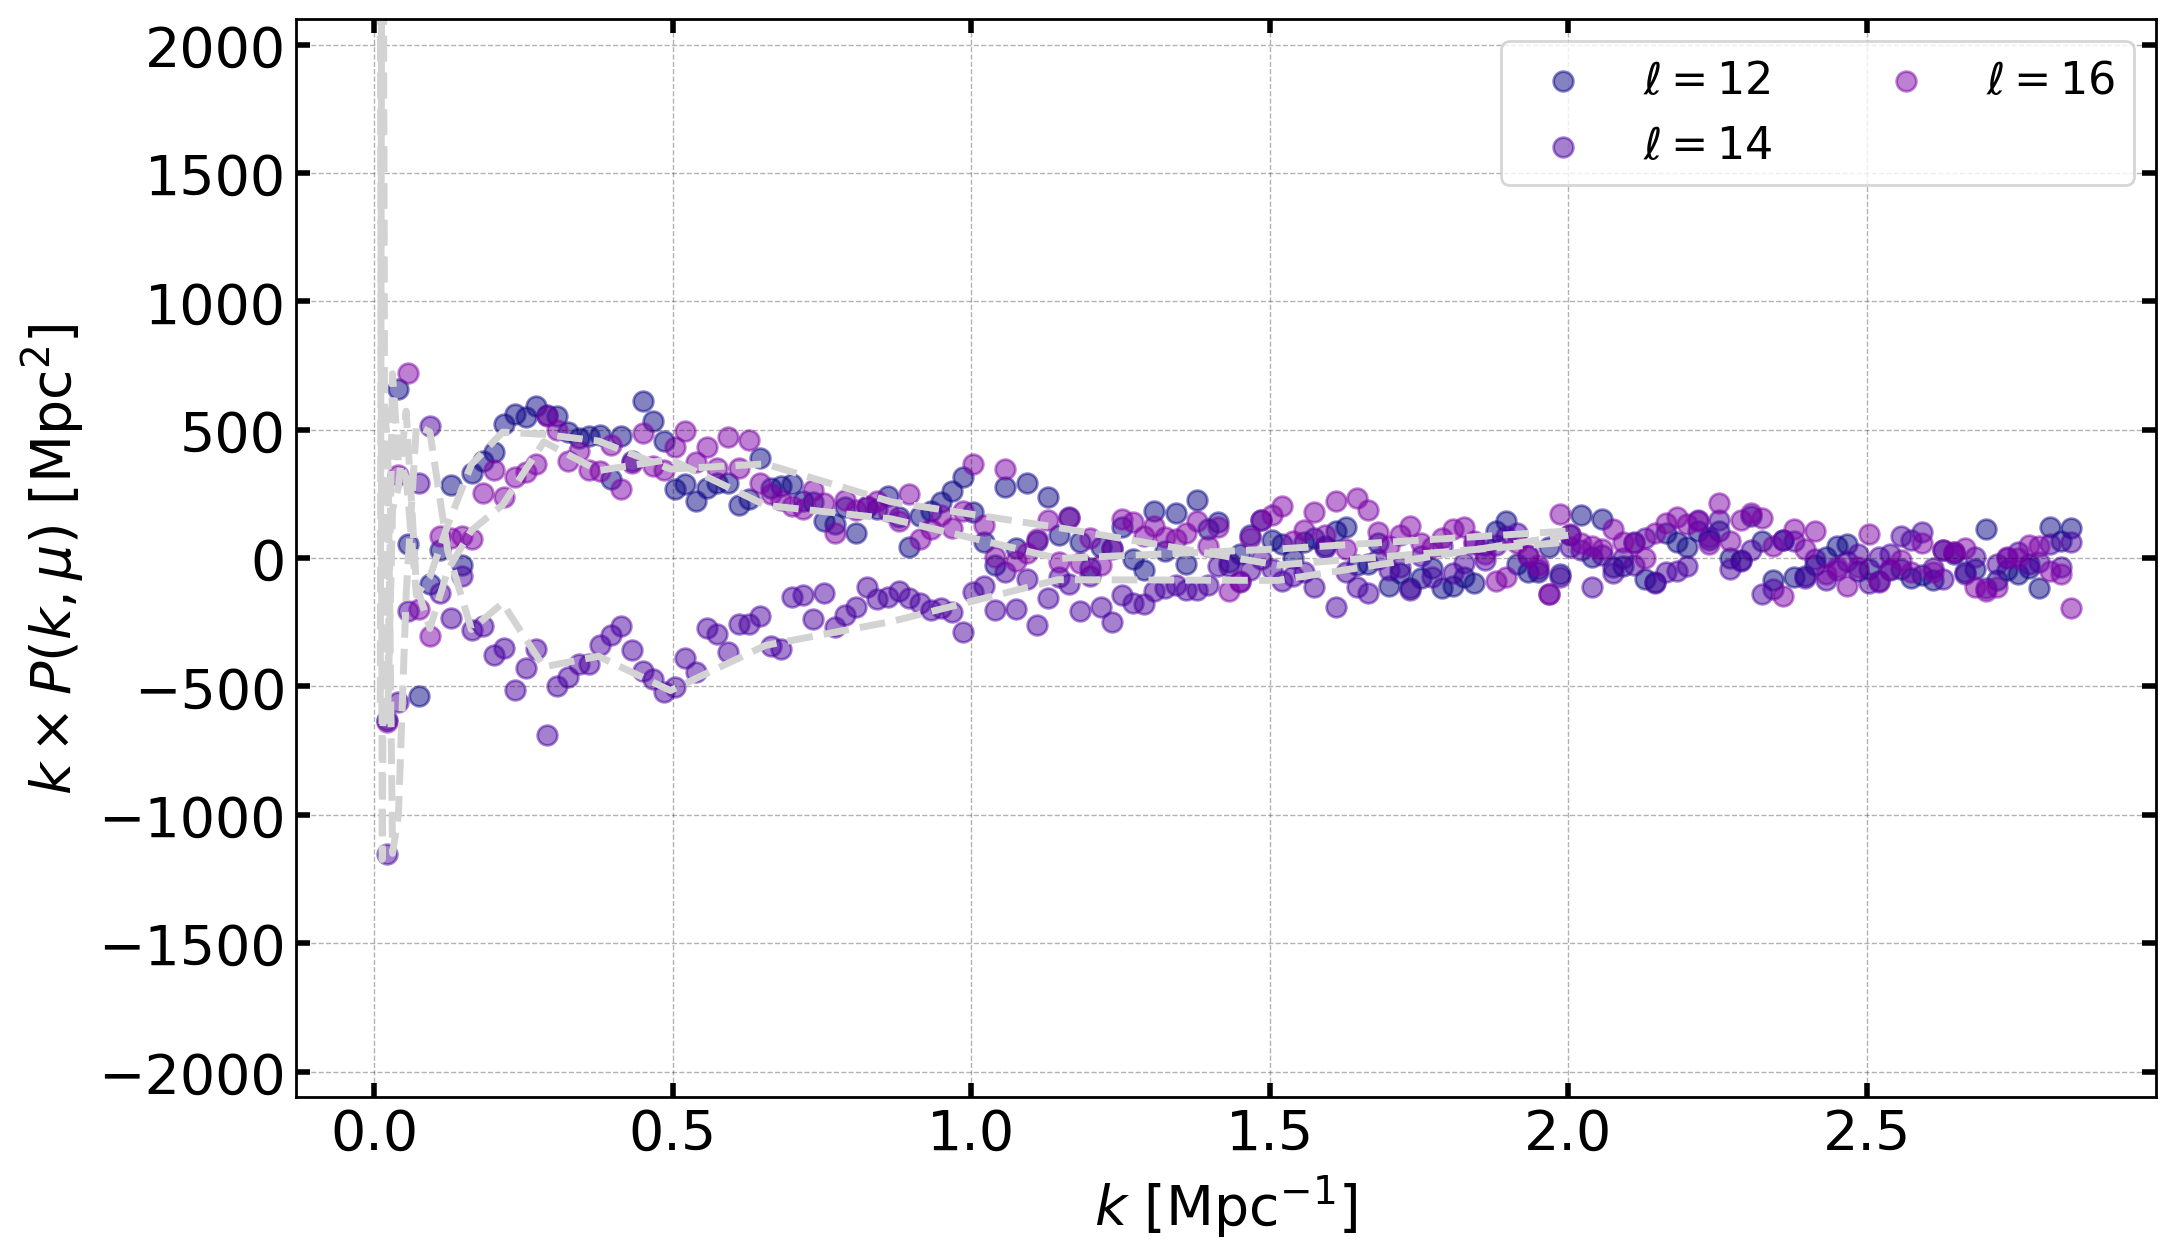

In [61]:
poles = powers[0].attrs['poles']
for i,ell in enumerate(poles[6:]):
    plot_pole(powers[0], ell, alpha=0.5, s=50, color=colors[i])

plt.ylim(-2100, 2100)
plt.legend(ncol=2)
plt.xlabel(kwargs['k'])
plt.ylabel(kwargs['pk'])

In [ ]:
np.arange(0, 32, 2)

In [223]:
# help(Pkmu.sel)#(kmin=0.1, kmax=1.0)

### Convert $P(k, \mu)$

Save files

In [33]:
pkmus = []
kmus = []
shotnoises = []
for i,self in enumerate(powers):
    Pkmu = self.to_pkmu(np.linspace(0,1.,6), 4)
    Pkmu.sel(k=slice(0.1, 0.8), method='nearest')
    Pkmu = Pkmu.reindex('k', 0.015)
    pkval = (Pkmu['power'].real - Pkmu.attrs['shotnoise'])#*h**3
    Pkmu.data['power'].real = Pkmu.data['power'].real -  Pkmu.attrs['shotnoise']
    pkmus.append(pkval)
    kmus.append(Pkmu['k'])
    shotnoises.append(Pkmu.attrs['shotnoise'])
    print('saved file:','../data/power_vec_box%i.npy'%i)
    np.save('../data/power_vec_box%i'%i,Pkmu.data)
    
mubins = Pkmu['mu'][0]

saved file: ../data/power_vec_box0.npy
saved file: ../data/power_vec_box1.npy


/global/homes/j/jesteves/.conda/envs/for-nbodykit/lib/python3.10/site-packages/nbodykit/binned_statistic.py:56: RuntimeWarning: Mean of empty slice
  ndarray = operation(ndarray, axis=-1*(i+1))


In [34]:
# help(Pkmu.reindex)

In [35]:
Pkmu.reindex('k', 0.05)

<BinnedStatistic: dims: (k: 44, mu: 5), variables: ('power', 'k', 'mu')>

In [36]:
# shot_noise = power_2d.attrs['volume'] / power_2d.attrs['N1']
powers[0].attrs

{'poles': [0, 2, 4, 6, 8, 10, 12, 14, 16],
 'dk': 0.0025,
 'kmin': 0.001,
 'kmax': 2.0,
 'Nmesh': array([1800, 1800, 1800]),
 'BoxSize': array([1127., 1618., 1031.]),
 'BoxPad': array([0.02, 0.02, 0.02]),
 'BoxCenter': array([ 447.26889614,  124.75289242, -401.09999639]),
 'mesh.resampler': 'tsc',
 'mesh.interlaced': False,
 'alpha': 0.07588164590952101,
 'data.norm': 2.197906334972144,
 'randoms.norm': 2.1959620897098877,
 'shotnoise': 10230.010972389746,
 'data.N': 89016,
 'data.W': 89016.0,
 'data.W2': 42853.97806027955,
 'data.num_per_cell': 7.3480757990877145e-06,
 'randoms.N': 1173090,
 'randoms.W': 1173090.0,
 'randoms.W2': 565494.9743523072,
 'randoms.num_per_cell': 9.696415883955884e-05,
 'data.ext': 1,
 'randoms.ext': 1}

In [37]:
mubins

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [38]:
def roll_average(k,pk, Np=5):
    is_nan = np.isnan(pk)
    y = uniform_filter1d(pk[~is_nan], size= int(k.size/10))
    return k[~is_nan][::Np], pk[~is_nan][::Np]

Text(0.5, 1.0, 'Buzzard Mock - Box 0')

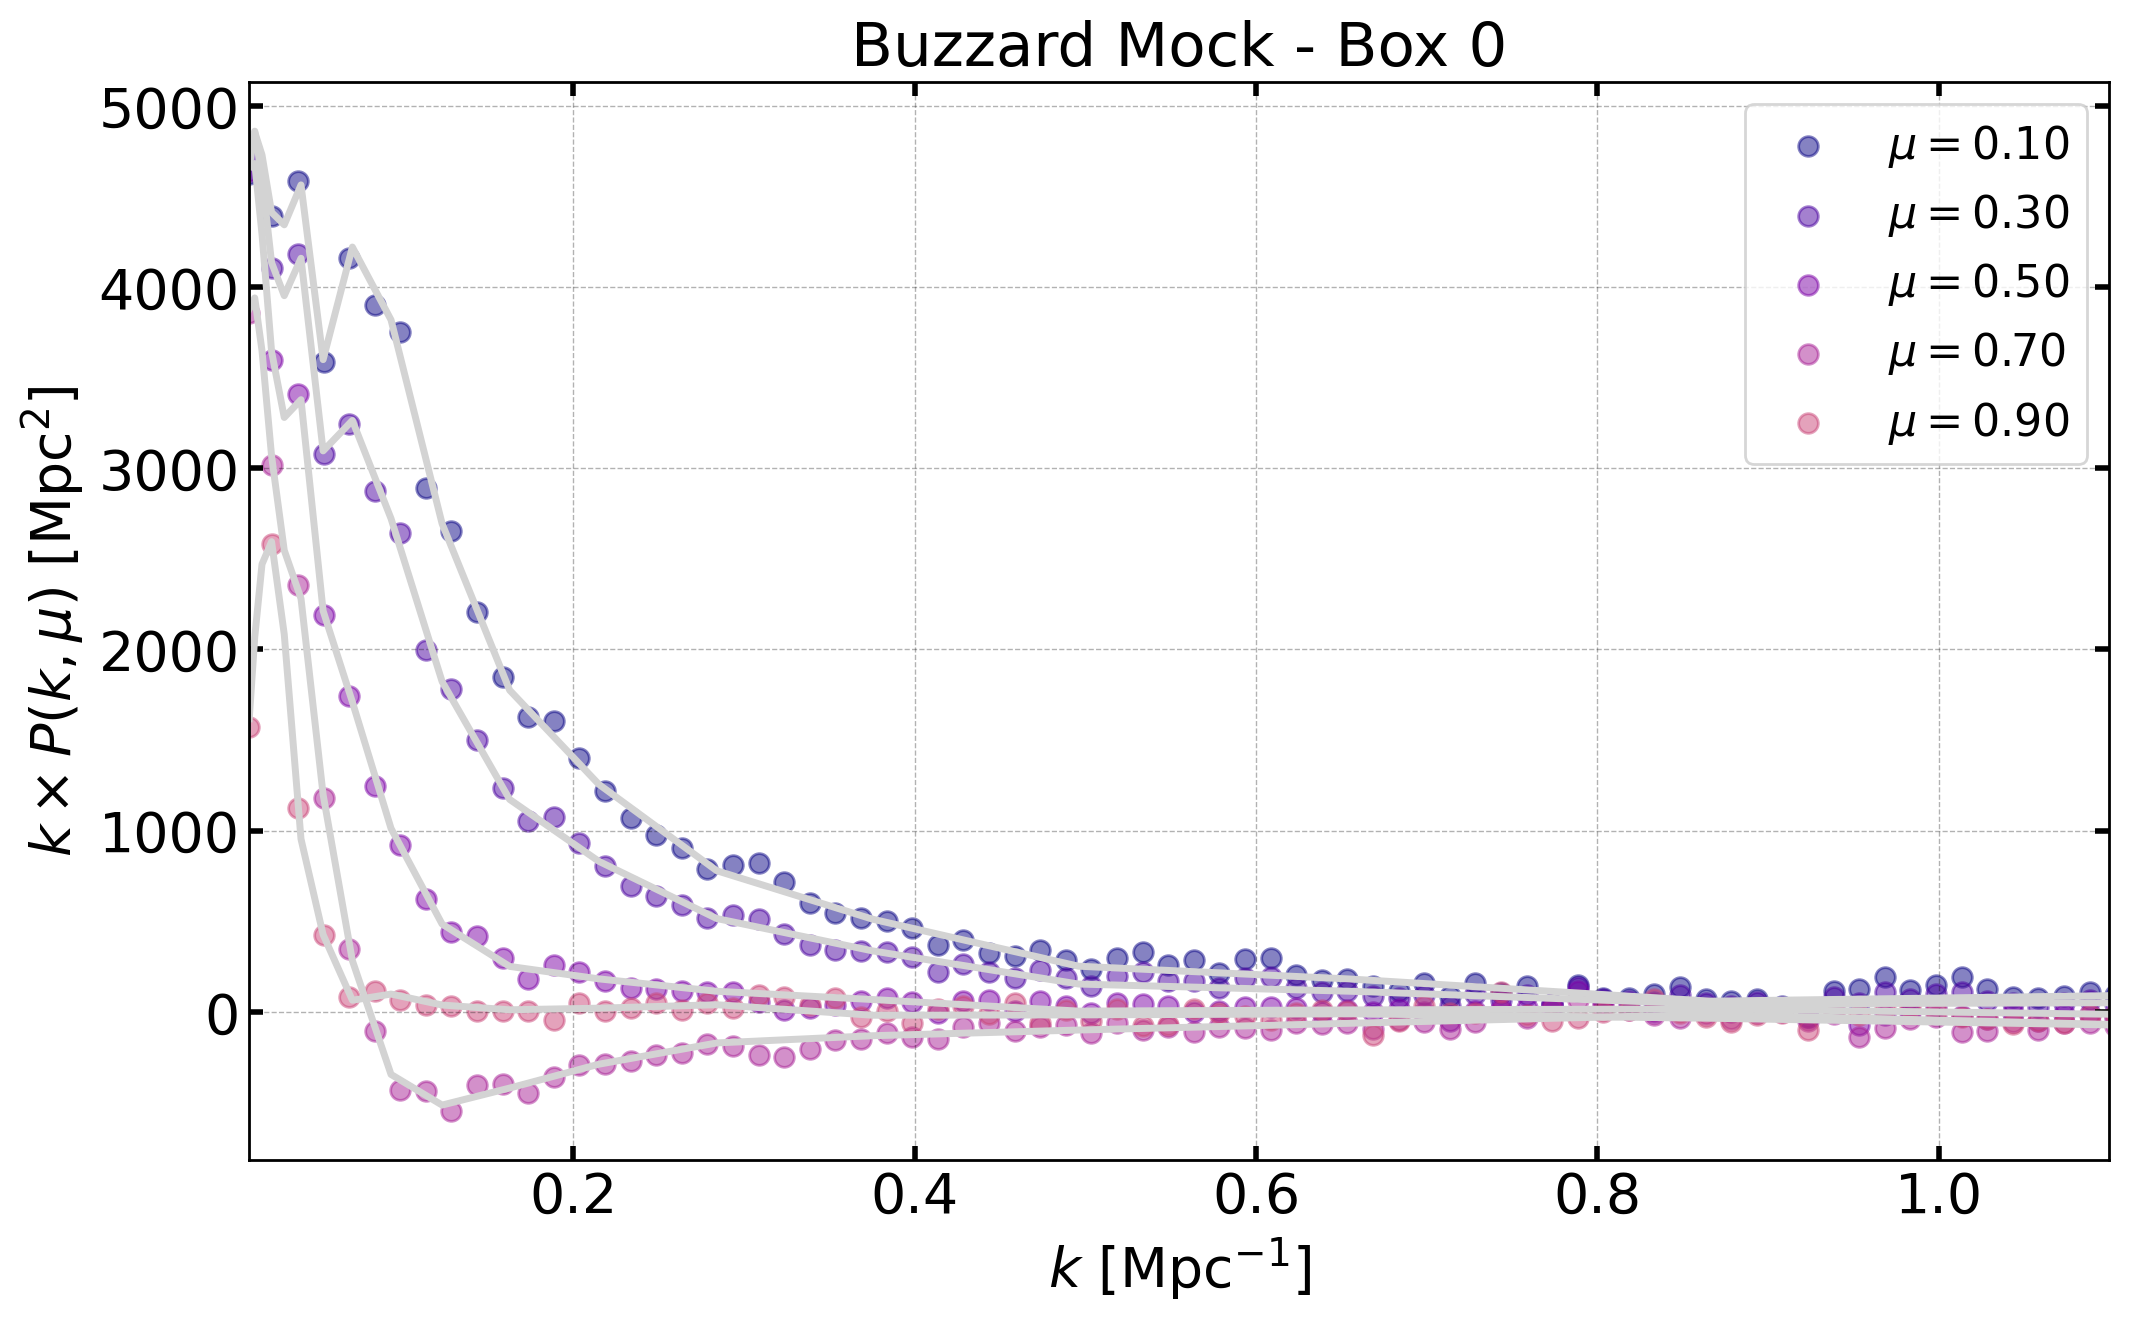

In [39]:
box_id = 0

for i in range(kmus[box_id].shape[1]):
    plt.scatter(kmus[box_id][:,i], kmus[box_id][:,i]*pkmus[box_id][:,i], alpha=0.5, s=50, color=colors[i])
plt.legend(labels=['$\mu =%.2f$'%mu for mu in Pkmu['mu'][0]])

for i in range(kmus[box_id].shape[1]):
    k_roll, pk_roll = roll_average(kmus[box_id][:,i], pkmus[box_id][:,i], Np=2)
    pk_interp_vec = interp_pk(kmus[box_id][:,i], pkmus[box_id][:,i])(kvec)
    plt.plot(kvec, kvec*pk_interp_vec, color='lightgray')

plt.xlabel(kwargs['k'])
plt.ylabel(kwargs['pk'])
# plt.ylim(1e3, 5.5e4)
# plt.xlim(0.01, 0.25)
plt.xlim(0.01,1.1)
plt.title('Buzzard Mock - Box %i'%box_id)

In [40]:
# for i in range(kmus[box_id].shape[1]):
#     ki = kmus[box_id][:,i]
#     pk_mui = pkmus[box_id][:,i]
#     plt.scatter(ki, pk_mui, alpha=0.5, s=100, color=colors[i],label='$\mu =%.2f$'% Pkmu['mu'][0][i])
#     kj, pk_interp_vec = interpSpline(ki, pk_mui)
    

In [41]:
# pkmus[box_id][:,i]

In [42]:
5*64

320

## Load CCL Power Spectrum

In [43]:
import pyccl as ccl
cosmoc = ccl.Cosmology(Omega_c=0.3, Omega_b=0.045, h=0.7, sigma8=0.83, n_s=0.96)

# Radius, wavenumber and mass
r_arr = np.geomspace(1E-3,1E2,256)
k_arr = np.geomspace(1E-3,1E2,256)
m_arr = np.geomspace(1E11,1E15,32)

# We will calculate everything at z=1 (scale factor = 0.5)
z = 0.1
a_sf = 1/(1+z)

# We will also use a mass definition with Delta = 200, and the Duffy 2008 concentration-mass relation
hmd_200c = ccl.halos.MassDef200c()
cM = ccl.halos.ConcentrationDuffy08(hmd_200c)

In [44]:
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

omega_m = 0.3
rhoc0 = cosmo0.critical_density0.to(u.Msun/u.Mpc**3).value
rhom0 = rhoc0*omega_m

def compute_cluster_power_spectrum(k_arr, z, mass, bias=2.15, mass_def=hmd_200c, conc=cM):
    # scaling factor
    a_sf = 1/(1+z)
    
    # non linear matter power spectrum 
    pk_2h = bias**2 * ccl.linear_matter_power(cosmoc, k_arr, a_sf)
    
    # NFW profile
    profNFW = ccl.halos.HaloProfileNFW(conc, truncated=False)
    rho_nfw = profNFW.fourier(cosmoc, k_arr, mass, a_sf, mass_def=mass_def)
    
    # given xi=(rho_nfw - rhom)/rhom, rhom is a number, then after the hankel transformation is only a multplication factor
    # the hankel transformation of a constant is a dirac at k=0, i.e. 0
    rhoc = cosmo0.critical_density(z).to(u.Msun/u.Mpc**3).value
    pk_1h = (rho_nfw)/(rhoc*omega_m)
    
    # total cluster power spectrum
    return pk_1h, pk_2h

Text(0.5, 1.0, 'Cluster Power Spectrum')

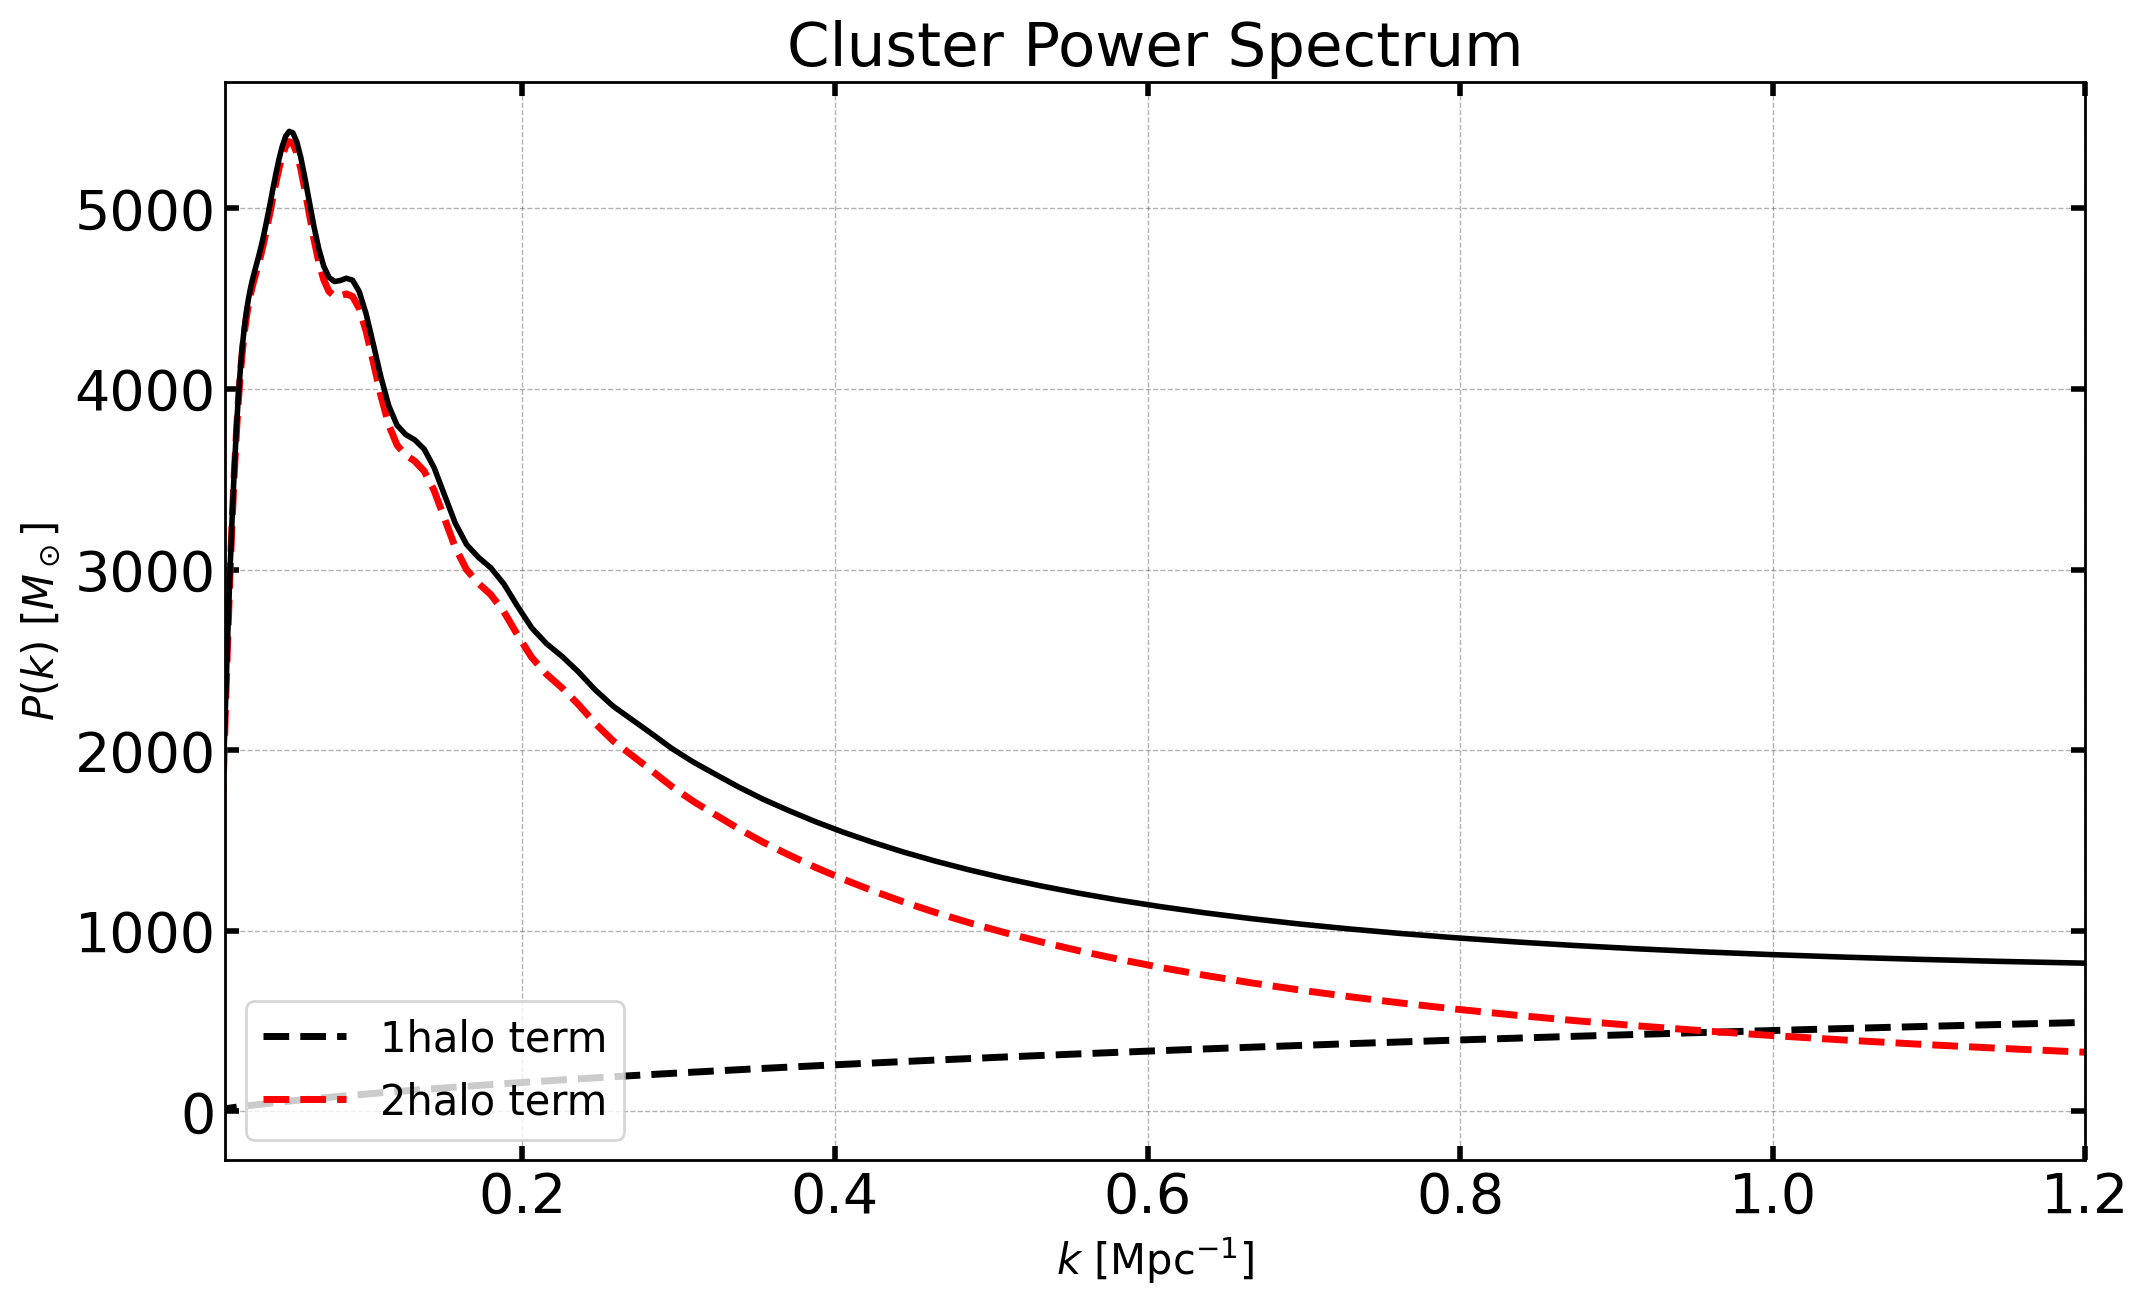

In [45]:
pk_1h, pk_2h = compute_cluster_power_spectrum(k_arr, 0.1, 1e13)
# pk_je = pk_nfw(k_arr, 0.1, 1e13, omega_m=0.3)

plt.plot(k_arr, k_arr*pk_1h, 'k--', label='1halo term')
plt.plot(k_arr, k_arr*pk_2h, 'r--', label='2halo term')
plt.plot(k_arr, k_arr*(pk_1h+pk_2h), 'k', lw=2)
# plt.plot(k_arr, k_arr*pk_je, 'b--', label='NFW')

# plt.xscale('log')
# plt.yscale('log')
plt.xlim(0.01, 1.2)
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$P(k)\,\,[M_\odot]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15);
plt.title('Cluster Power Spectrum')

In [46]:
def get_pk_1h(k_arr, mass, z):
    a_sf = 1/(1+z)
    # NFW profile
    profNFW = ccl.halos.HaloProfileNFW(conc, truncated=False)
    rho_nfw = profNFW.fourier(cosmoc, k_arr, mass, a_sf, mass_def=mass_def)
    
    # given xi=(rho_nfw - rhom)/rhom, rhom is a number, then after the hankel transformation is only a multplication factor
    # the hankel transformation of a constant is a dirac at k=0, i.e. 0
    rhoc = cosmo0.critical_density(z).to(u.Msun/u.Mpc**3).value
    pk_1h = (rho_nfw)/(rhoc*omega_m)
    return pk_1h

### Linear Model
The linear model is given by:
$$
P(k,\mu) = b^2 P(k) (1+\beta^2 \mu^2)^2 
$$

Where $\beta=f/b$ and $f$ is log of the growth factor, which has a value of $f=0.76$

In [47]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

f=0.7
m200 = 5e13
kmin, kmax = 0.05, 0.4
zmeans = [0.3, 0.5]

bias = []
pk_cls_funcs = []
for box_id in range(1):
    r1 = []
    for mu_id in range(mubins.size):
        mui = mubins[mu_id]
        pk_1h, pk_2h = compute_cluster_power_spectrum(k_arr, zmeans[box_id], m200)
        pk_2h_interp = interp1d(k_arr, pk_2h)
        pk_1h_interp = interp1d(k_arr, pk_1h)

        pk_cls = lambda x, b: x*(pk_1h_interp(x) + b**2*pk_2h_interp(x))

        # kmin, kmax
        ki = kmus[box_id][:,mu_id]
        pk_mui = pkmus[box_id][:,mu_id]

        mask = (ki>=kmin)&(ki<=kmax)

        popt, pcov = curve_fit(pk_cls, ki[mask], ki[mask]*pk_mui[mask])
        r1.append(float(popt))
    bias.append(r1)

/global/homes/j/jesteves/.conda/envs/for-nbodykit/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [48]:
def bias_eff(mu,b0,f):
    return b0*(1+((b0/f)*mu)**2)
    #return b0+ a*(mu)+ b*(mu)**2 #b0*(1+(beta*mu)**2+(beta2*mu)**3+(beta3*mu)**5)

params = []
for i in range(1):
    popt, pcov = curve_fit(bias_eff, mubins, bias[i])
    params.append(popt)

In [49]:
def pk_mu_model(x, z, m200, mu=0., box_id=0):
    pk_1h, pk_2h = compute_cluster_power_spectrum(k_arr, z, m200)
    pk_2h_interp = interp1d(k_arr, pk_2h)
    pk_1h_interp = interp1d(k_arr, pk_1h)
    beff = bias_eff(mu, *params[box_id])
    pk_total = pk_1h_interp(x) + beff**2 * pk_2h_interp(x)
    return pk_1h_interp(x), pk_total

Text(0.5, 1.0, 'Buzzard Mock - Box 0')

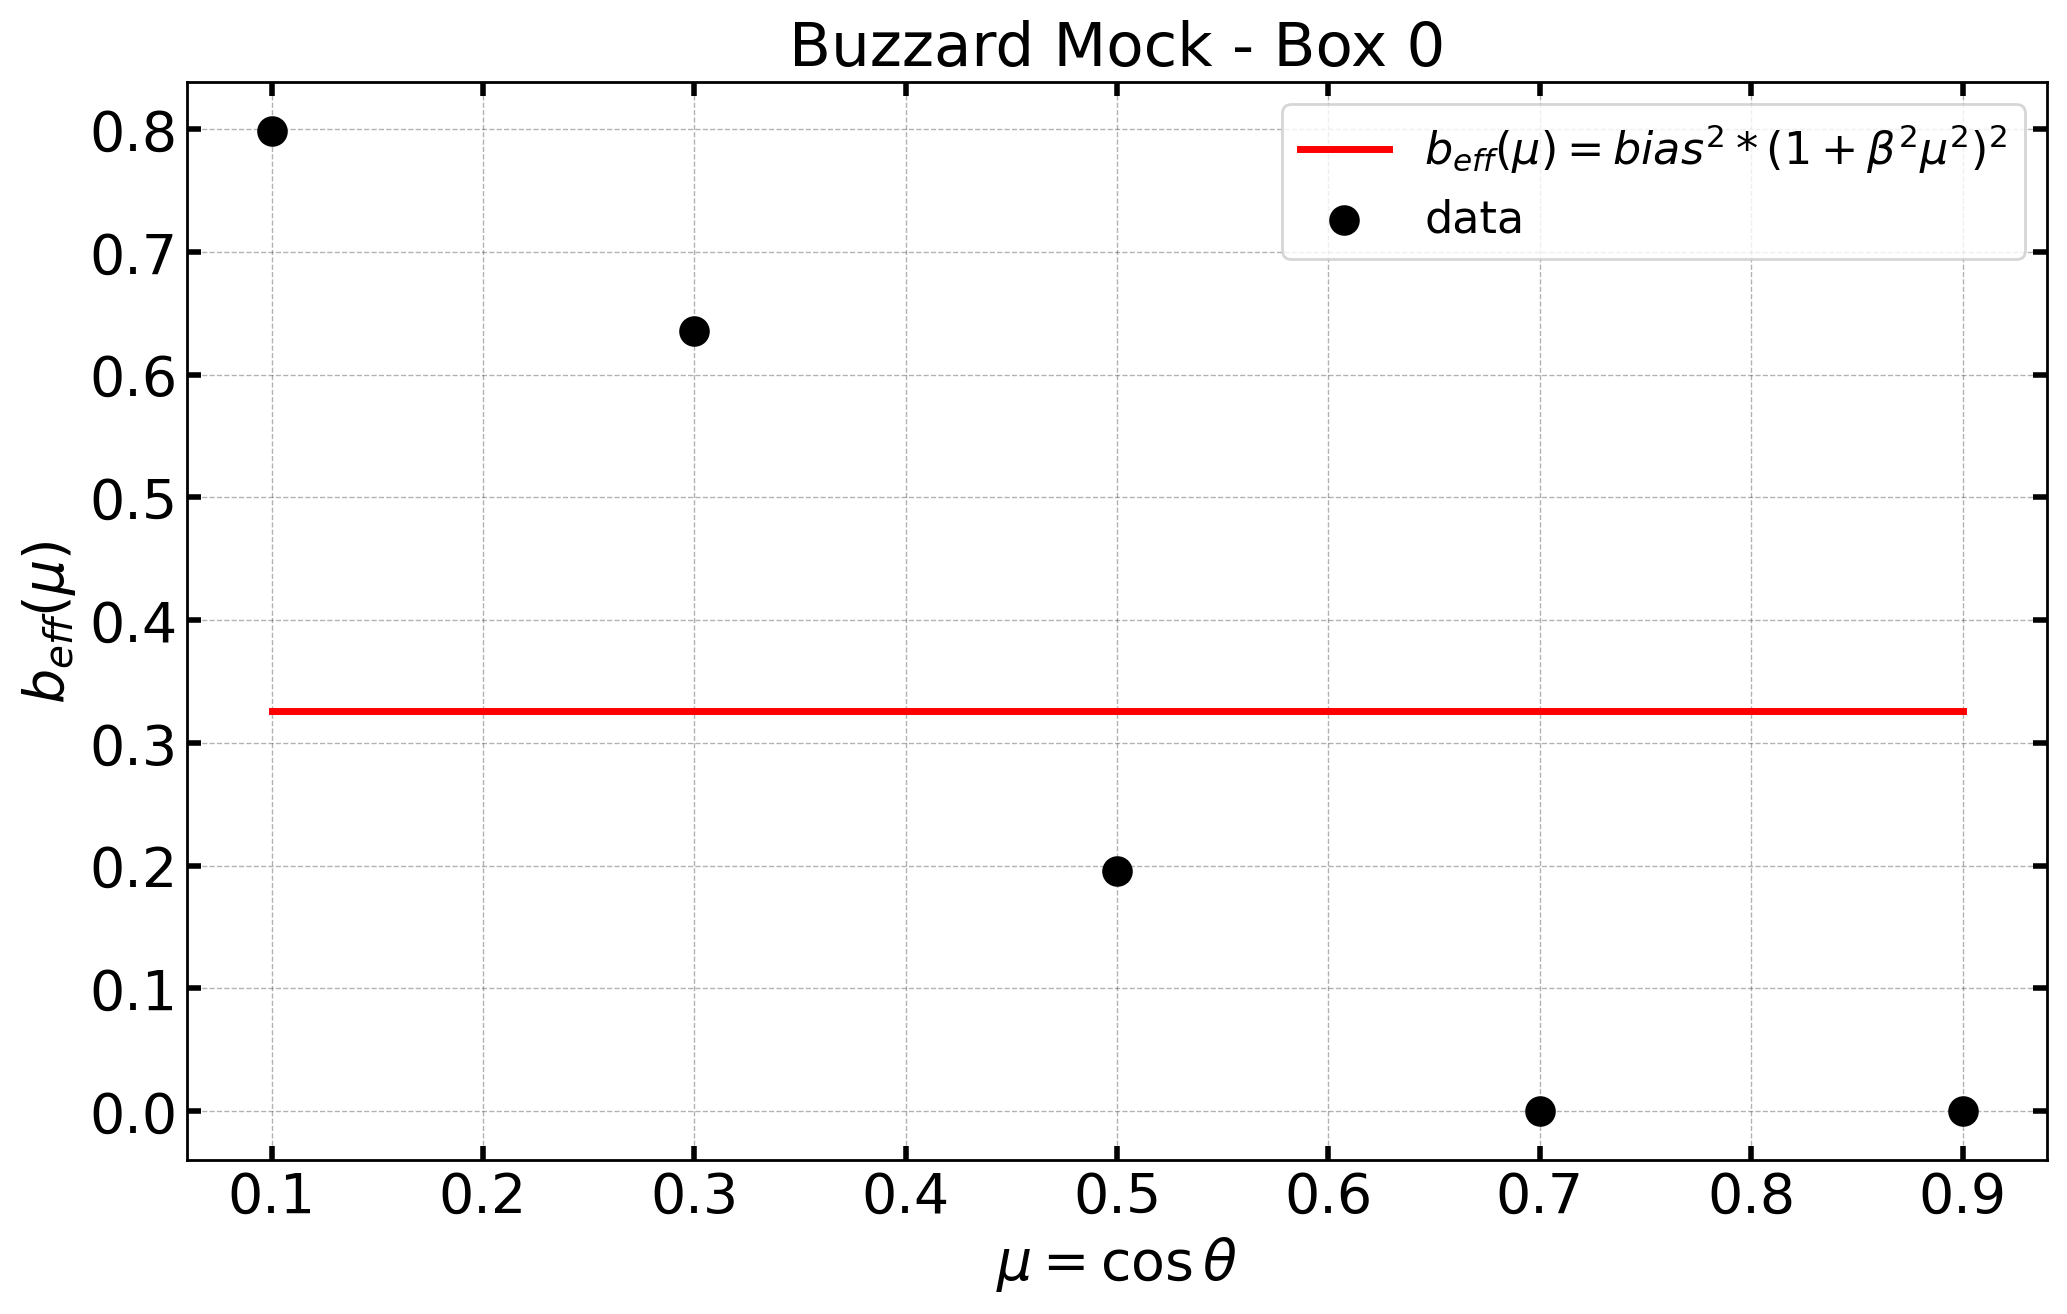

In [50]:
box_id = 0
beff = bias_eff(mubins,*params[box_id])
plt.plot(mubins, beff, 'r', label=r'$b_{eff}(\mu) = bias^2*(1+\beta^2\mu^2)^2 $')
plt.scatter(mubins, bias[box_id], color='k', label='data')
plt.legend()
plt.xlabel(r'$\mu = \cos{\theta}$')
plt.ylabel(r'$b_{eff}(\mu)$')
plt.title('Buzzard Mock - Box %i'%box_id)

In [51]:
params[box_id]

array([3.25941825e-01, 1.51466607e+03])

/tmp/ipykernel_13697/1768614731.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(ki, pk_cls,'k', ls='--', color=colors[i])


Text(0.5, 1.0, 'Buzzard Mock - Box 0')

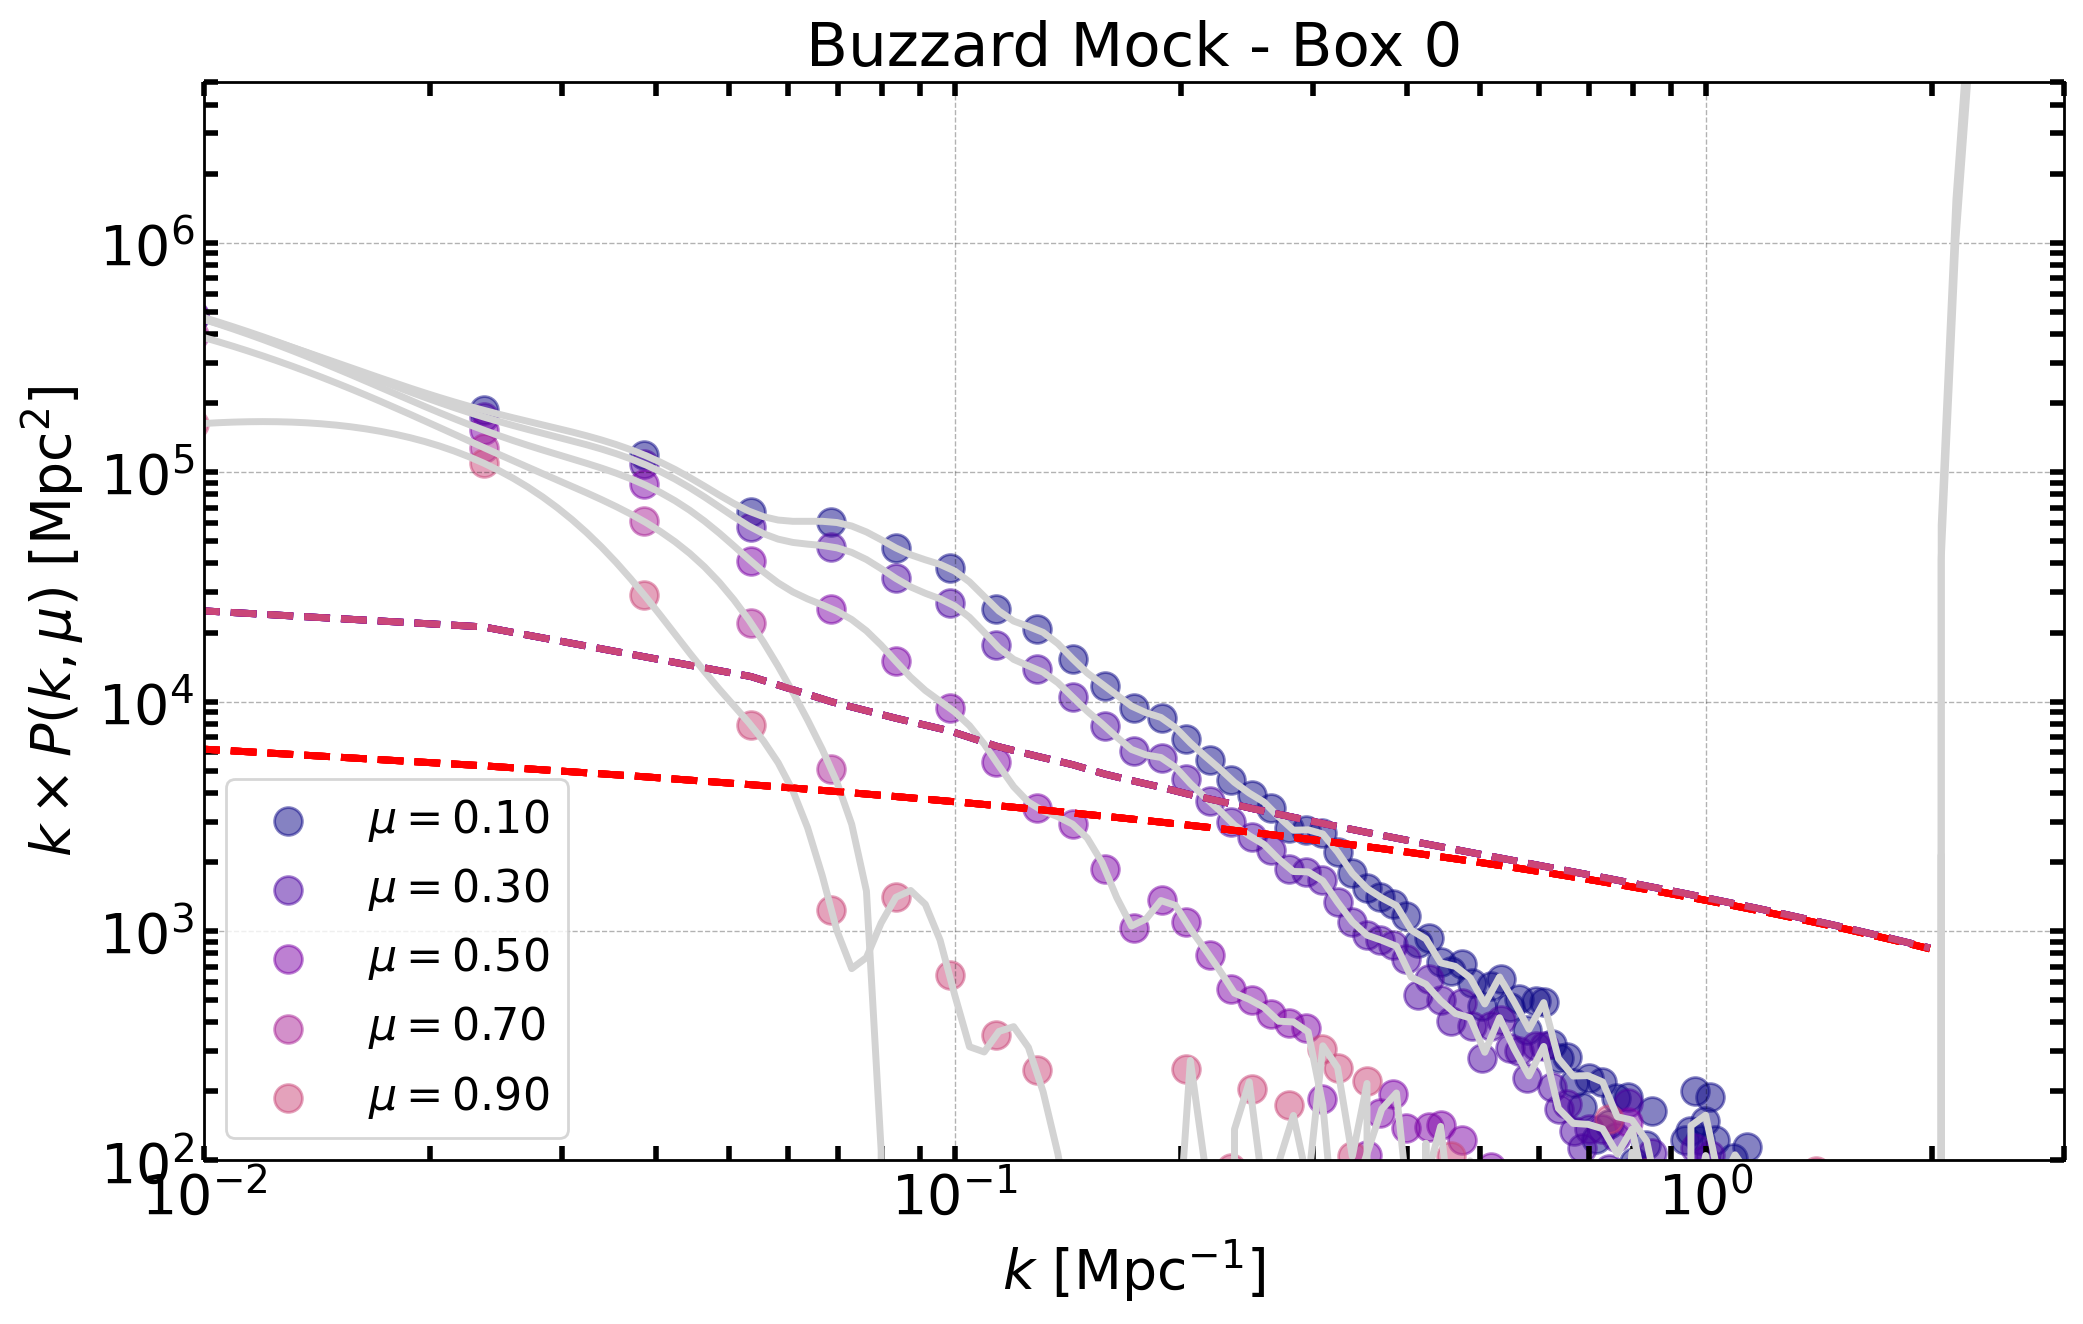

In [52]:
box_id = 0
plt.loglog()
for i in range(kmus[box_id].shape[1]):
    ki = kmus[box_id][:,i]
    pk_mui = pkmus[box_id][:,i]
    plt.scatter(ki, pk_mui, alpha=0.5, s=100, color=colors[i],label='$\mu =%.2f$'% Pkmu['mu'][0][i])
    kj, pk_interp_vec = interpSpline(ki, pk_mui)
    plt.plot(kj, pk_interp_vec, color='lightgray',label=None)
    
    # model
    pk_1h, pk_cls = pk_mu_model(ki, zmeans[box_id], m200, mu=mubins[i], box_id=box_id)
    plt.plot(ki, pk_1h,'r--')
    plt.plot(ki, pk_cls,'k', ls='--', color=colors[i])

    
plt.legend()
plt.xlabel(kwargs['k'])
plt.ylabel(kwargs['pk'])
plt.ylim(1e2, 5e6)
# plt.xlim(0.01, 0.25)
plt.xlim(0.01, 3.0)
plt.title('Buzzard Mock - Box %i'%box_id)

In [53]:
def model(x, mu, m200=6e14, box_id=0):
    z = zmeans[box_id]
    pk_1h, pk_2h = compute_cluster_power_spectrum(k_arr, z, m200)
    pk_2h_interp = interp1d(k_arr, pk_2h)
    pk_1h_interp = interp1d(k_arr, pk_1h)
    beff = bias_eff(mu, *params[box_id])
    
    pk_total = np.zeros((x.size, mu.size))
    for i in range(x.size):
        pk_total[i] = pk_1h_interp(x[i]) + beff**2 * pk_2h_interp(x[i])
    return pk_total

In [54]:
def periodic_gaussian_covariance(k, mu_edges, nbar, volume, Nmu=100, m200=6e14, box_id=0):
    r"""
    Return the Gaussian prediction for the covariance between
    :math:`P(k,\mu)` wedges for a periodic box simulation, where the number
    density is constant.
    See eq. 17 of Grieb et al. 2015 arxiv:1509.04293
    Parameters
    ----------
    model : GalaxySpectrum, QuasarSpectrum
        the model instance used to evaluate the theoretical :math:`P(k,\mu)`
    k : array_like
        the array of wavenumbers (units of :math:`h/\mathrm{Mpc}`) where
        the covariance matrix will be evaluated
    mu_edges : array_like
        the edges of the :math:`\mu` bins
    nbar : float
        the constant number density in the box in units of
        :math:`(\mathrm{Mpc}/h)^{-3}` -- the shot noise contribution
        to the covariance is the inverse of this value
    volume : float
        the volume of the box, in units of :math:`(\mathrm{Mpc}/h)^3`
    Nmu : int, optional
        the number of mu bins to use when performing the multipole integration
        over :math:`\mu`
    Returns
    -------
    PkmuCovarianceMatrix :
        the covariance matrix object holding the Gaussian prediction for
        the covariance between the specified wedges
    Examples
    --------
    >>> import numpy
    >>> from pyRSD.rsd import GalaxySpectrum
    >>> from pyRSD.rsdfit.data import PkmuCovarianceMatrix
    >>> volume = 1380.0**3
    >>> nbar = 3e-4
    >>> model = GalaxySpectrum(params='boss_dr12_fidcosmo.ini')
    >>> k = numpy.arange(0., 0.4, 0.005) + 0.005/2
    >>> mu_edges = [0., 0.2, 0.4, 0.6, 0.8, 1.0]
    >>> C = PkmuCovarianceMatrix.periodic_gaussian_covariance(model, k, ells, nbar, volume)
    """
    Nwedge = len(mu_edges) - 1
    ndims = (len(k)+2, Nwedge+2)
    mu_edges = np.asarray(mu_edges)

    # the best-fit P(k,mu)
    fine_mu_edges = np.linspace(0, 1, Nmu+1)
    mu_cen = 0.5*(fine_mu_edges[1:] + fine_mu_edges[:-1])
    
    # Replace here
    Pkmu = model(k, mu_cen, m200, box_id)
    
    _, mus = np.meshgrid(k, mu_cen, indexing='ij')

    # determine the mu indices for binning
    k_idx = np.arange(len(k), dtype=int)[:,None]
    dig_k = np.repeat(k_idx, Nmu, axis=1) + 1
    dig_mu = np.digitize(mus, mu_edges)
    mu_indices = np.ravel_multi_index([dig_k, dig_mu], ndims)

    # determine the number of modes
    dk = np.diff(k).mean()
    Vk  = 4*np.pi*k**2*dk
    N = Vk * volume / (2*np.pi)**3
    N = np.repeat(N[:,None], Nmu, axis=1) * np.diff(fine_mu_edges)

    Psq = (Pkmu + 1./nbar)**2

    def bin(d, average=False):
        toret = np.zeros(ndims)
        minlength = np.prod(ndims)
        toret.flat = np.bincount(mu_indices.flat, weights=d.flat, minlength=minlength)
        norm = 1.0
        if average:
            norm = np.zeros(ndims)
            norm.flat = np.bincount(mu_indices.flat, minlength=minlength)
            norm = np.squeeze(norm.reshape(ndims)[1:-1, 1:-1])
        toret = np.squeeze(toret.reshape(ndims)[1:-1, 1:-1])
        return toret/norm

    Psq = bin(Psq, average=True)
    modes = bin(N, average=False)

    N1 = len(k); N2 = Nwedge
    C = numpy.zeros((N1,N2)*2)
    for i in range(Nwedge):
        C[:,i,:,i] = np.diag(np.nan_to_num(2*Psq[:,i]/modes[:,i]))

    C = C.reshape((N1*N2,)*2, order='F')

    # the coordinate arrays
    k_coord = np.concatenate([k for i in range(Nwedge)])
    mu_cen = (mu_edges[1:] + mu_edges[:-1])*0.5
    mu_coord = np.concatenate([np.ones(len(k), dtype=int)*mu for mu in mu_cen])

    return C, k_coord, mu_coord

In [55]:
nbar = 2e-3/8
volume = 1024**3
Nmu = Nell = 5
mu_edges = numpy.linspace(0, 1, Nmu+1)

In [56]:
cov, kcoord, mucoord = periodic_gaussian_covariance(kvec, mu_edges, nbar, volume, Nmu=100)

In [57]:
nbar/1e-4

2.5

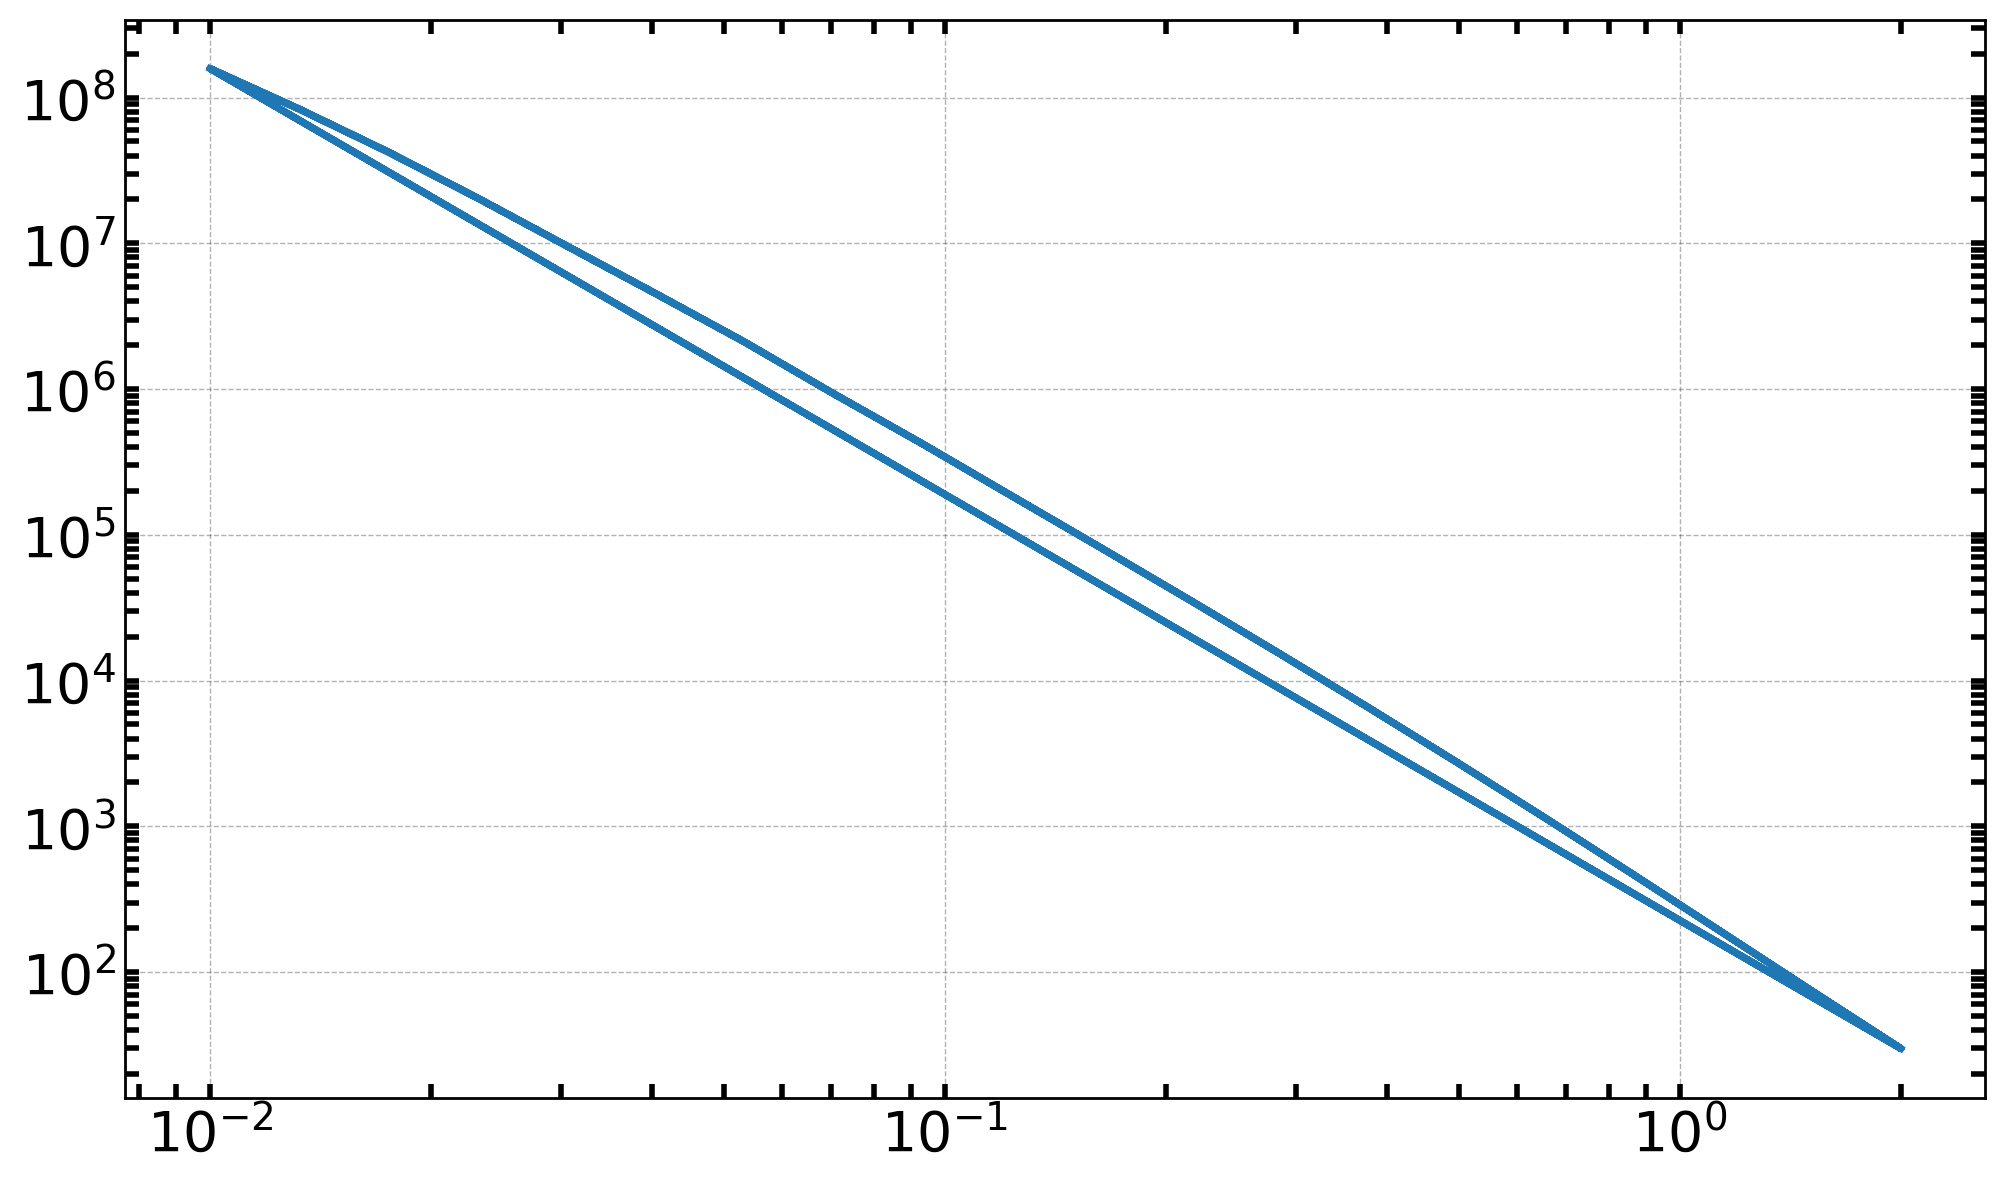

In [58]:
plt.loglog(kcoord, np.diag(cov))

In [59]:
sig = np.diag(cov)

/tmp/ipykernel_57922/1020560975.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(ki, ki*pk_cls,'k', ls='--', color=colors[i])


Text(0.5, 1.0, 'Buzzard Mock - Box 0')

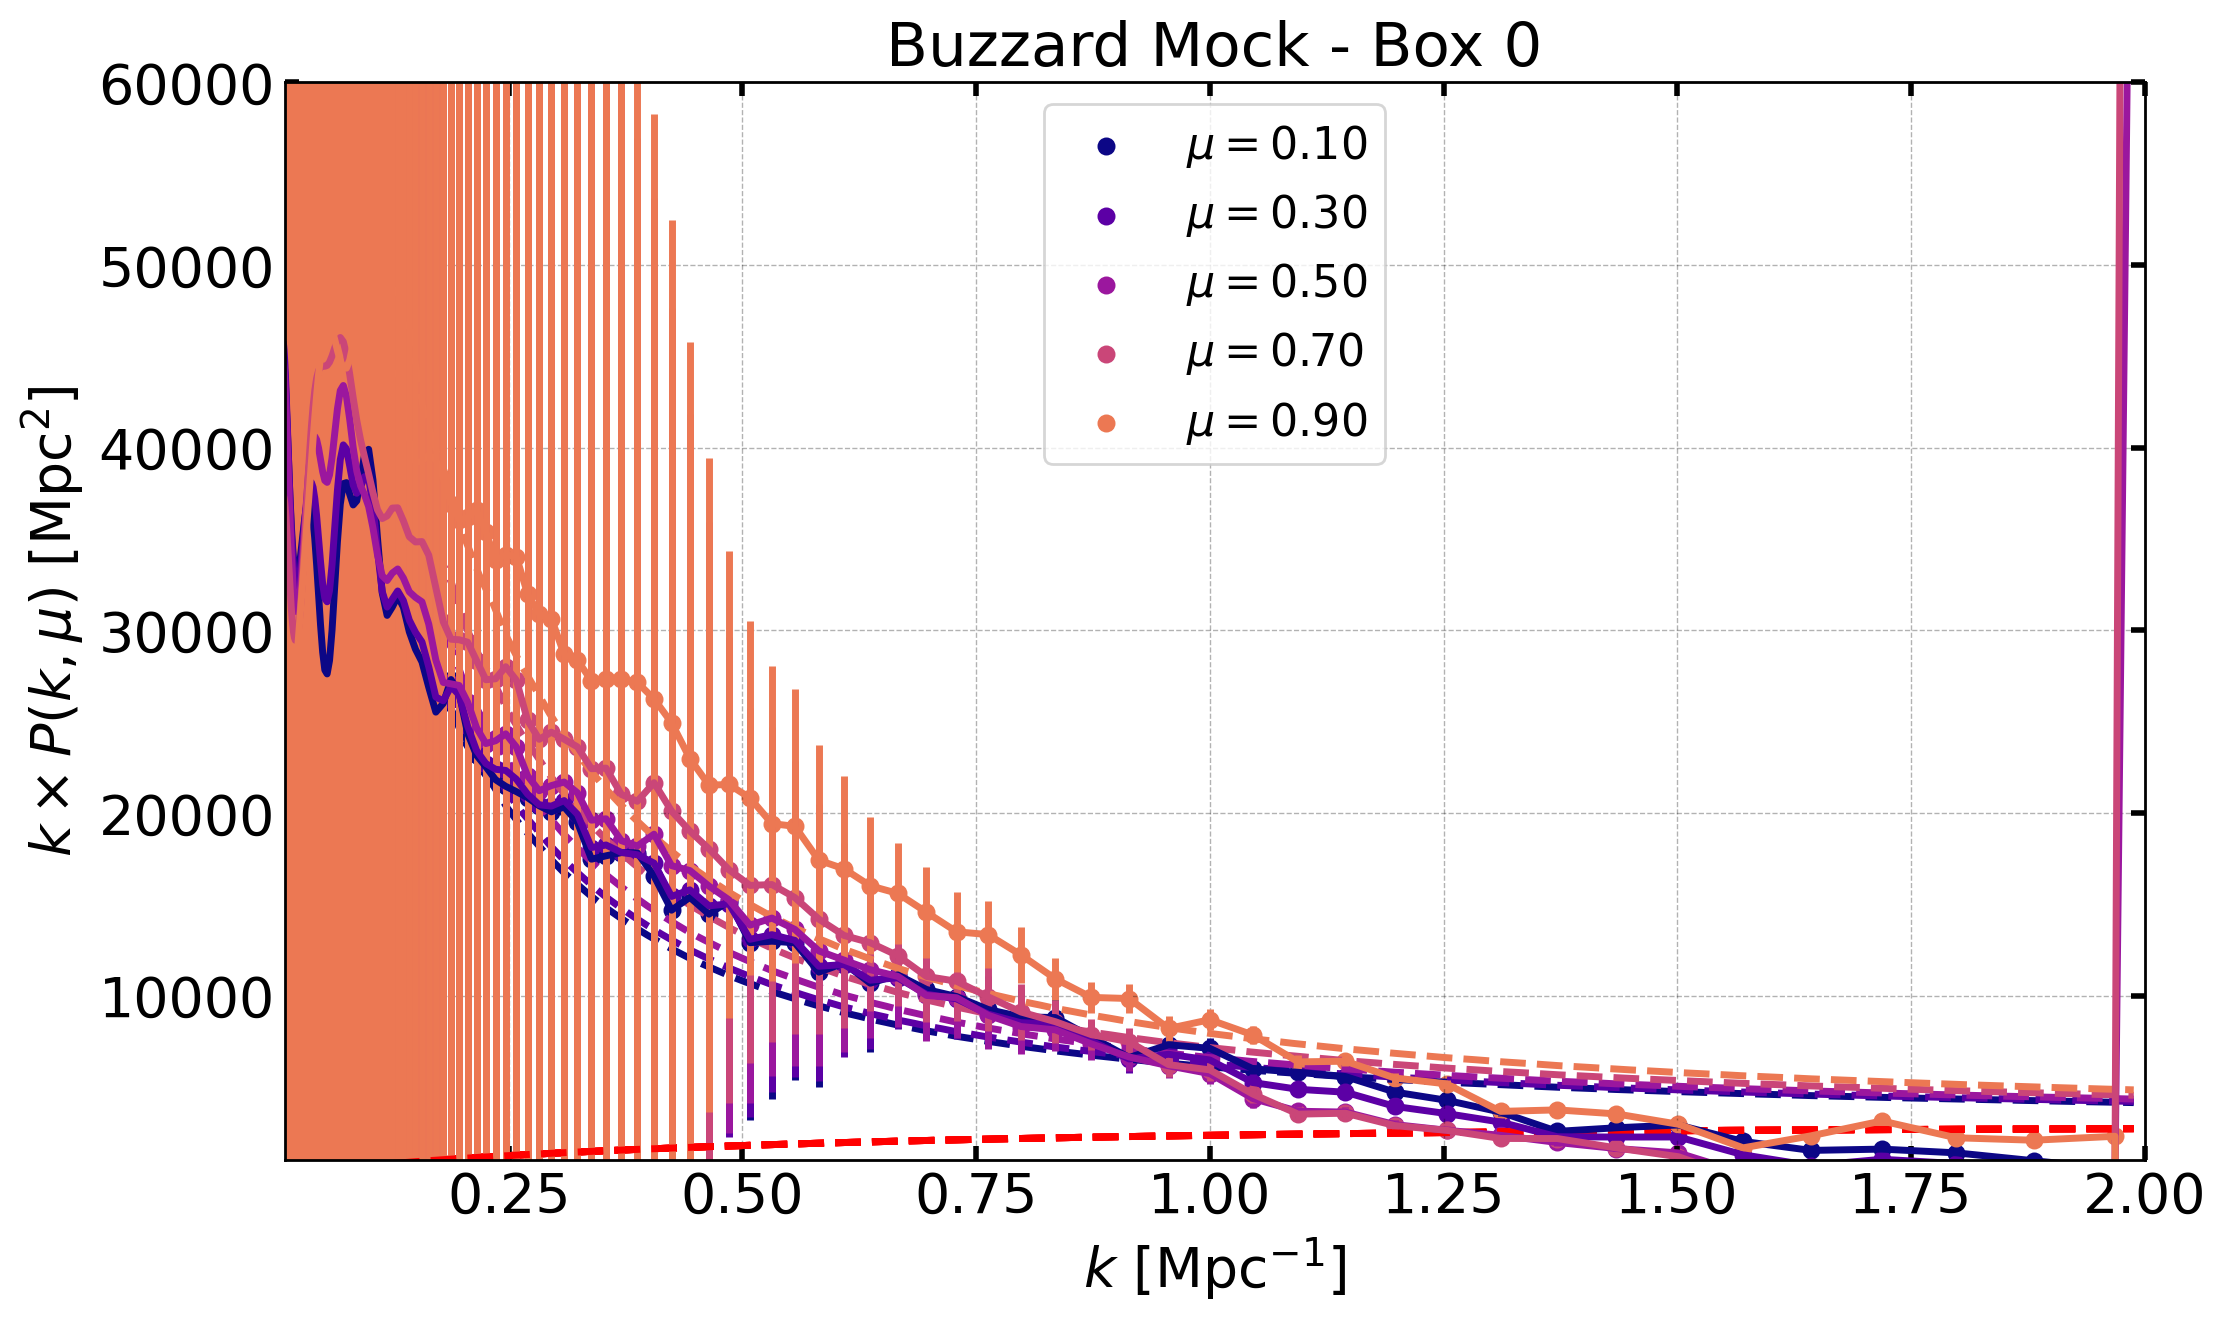

In [318]:
box_id = 0
# plt.loglog()
for i in range(kmus[box_id].shape[1]):
    ki = kmus[box_id][:,i]
    pk_mui = pkmus[box_id][:,i]
    #plt.scatter(ki, ki*pk_mui, alpha=0.5, s=100, color=colors[i],label='$\mu =%.2f$'% Pkmu['mu'][0][i])
    kj, pk_interp_vec = interpSpline(ki, pk_mui)
    plt.scatter(kj, kj*pk_interp_vec, color=colors[i], s=30, label='$\mu =%.2f$'% Pkmu['mu'][0][i])
    plt.errorbar(kj, kj*pk_interp_vec, color=colors[i], yerr=np.interp(kj, kcoord, sig))
                 
    # model
    pk_1h, pk_cls = pk_mu_model(ki, zmeans[box_id], m200, mu=mubins[i], box_id=box_id)
    plt.plot(ki, ki*pk_1h,'r--')
    plt.plot(ki, ki*pk_cls,'k', ls='--', color=colors[i])
    #plt.errorbar(ki, ki*pk_1h, yerr=ki*sig)

    
plt.legend()

# # bias = 4.2
# pk_1h, pk_cls = pk_mu_model(ki, zmeans[box_id], m200, mu=0., box_id=box_id)
# plt.plot(ki, ki*pk_1h,'r--')
# plt.plot(ki, ki*pk_cls,'k')
    
# plt.plot(ki, ki*pk_1h_interp(ki),'r--',label='1h term')
# plt.plot(ki, pk_cls(ki, bias[box_id+1]),'k',label='CAMB')
plt.legend()    
plt.xlabel(kwargs['k'])
plt.ylabel(kwargs['pk'])
plt.ylim(1e3, 60e3)
# plt.xlim(0.01, 0.25)
plt.xlim(0.01,2.0)
plt.title('Buzzard Mock - Box %i'%box_id)

In [303]:
# from matplotlib.colors import LogNorm, PowerNorm
# from scipy.ndimage.filters import gaussian_filter

# coefs = np.corrcoef(cov)

# cmap = 'plasma'
# vmin, vmax = 0.01, 1.
# plt.figure(figsize=(10,10))
# img = plt.imshow(gaussian_filter(coefs, 0.15), origin='lower', norm=PowerNorm(gamma=4, vmin=vmin, vmax=vmax), cmap=cmap)


In [ ]:
from scipy.integrate import quad, fixed_quad

def compute_covariance(muedges, kedges, box_id=0, m200=m200):
    z = zmeans[box_id]
    shot_noise = shotnoises[box_id]
    
    dmu = np.diff(muedges)[0] 
    Vk = (4*np.pi/3)*(kedges[1:]**3-kedges[:-1]**3)
    Norm = 4*np.pi/Vk/dmu**2
    
    covs = []
    for j in range(mubins.size-1):
        muvec = np.linspace(mubins[j],mubins[j+1],20)
        
        integrand = [(pk_mu_model(kedges, z, m200, mu=mui, box_id=box_id)[1]+shot_noise)**2 for mui in muvec]
        res = np.trapz(np.array(integrand), x=muvec, axis=0)
        pk_avg = interp1d(kedges, res*kedges**2, kind='nearest')
        
        cov_diag = [fixed_quad(pk_avg, kl, ku)[0] for kl, ku in zip(kedges[:-1], kedges[1:])]
        cov = np.diag(np.array(cov_diag))
        covs.append(cov)
    return covs


In [260]:
covs = compute_covariance(Pkmu.edges['mu'], kvec)

In [95]:
vol_min = cosmo0.comoving_volume(zmin_list).value
vol_max = cosmo0.comoving_volume(zmax_list).value

Vsurvey = vol_max-vol_min
volume = (Pkmu.attrs['data.N']/shotnoises[0])*1e7
# volume = 1800**3
Nki = 4*np.pi*kvec[1:]*np.diff(kvec)*volume/(2*np.pi)**3

In [96]:
1800**3*1e-9

5.832000000000001

In [102]:
shotnoises

[75472.97833514471, 91538.10279523292]

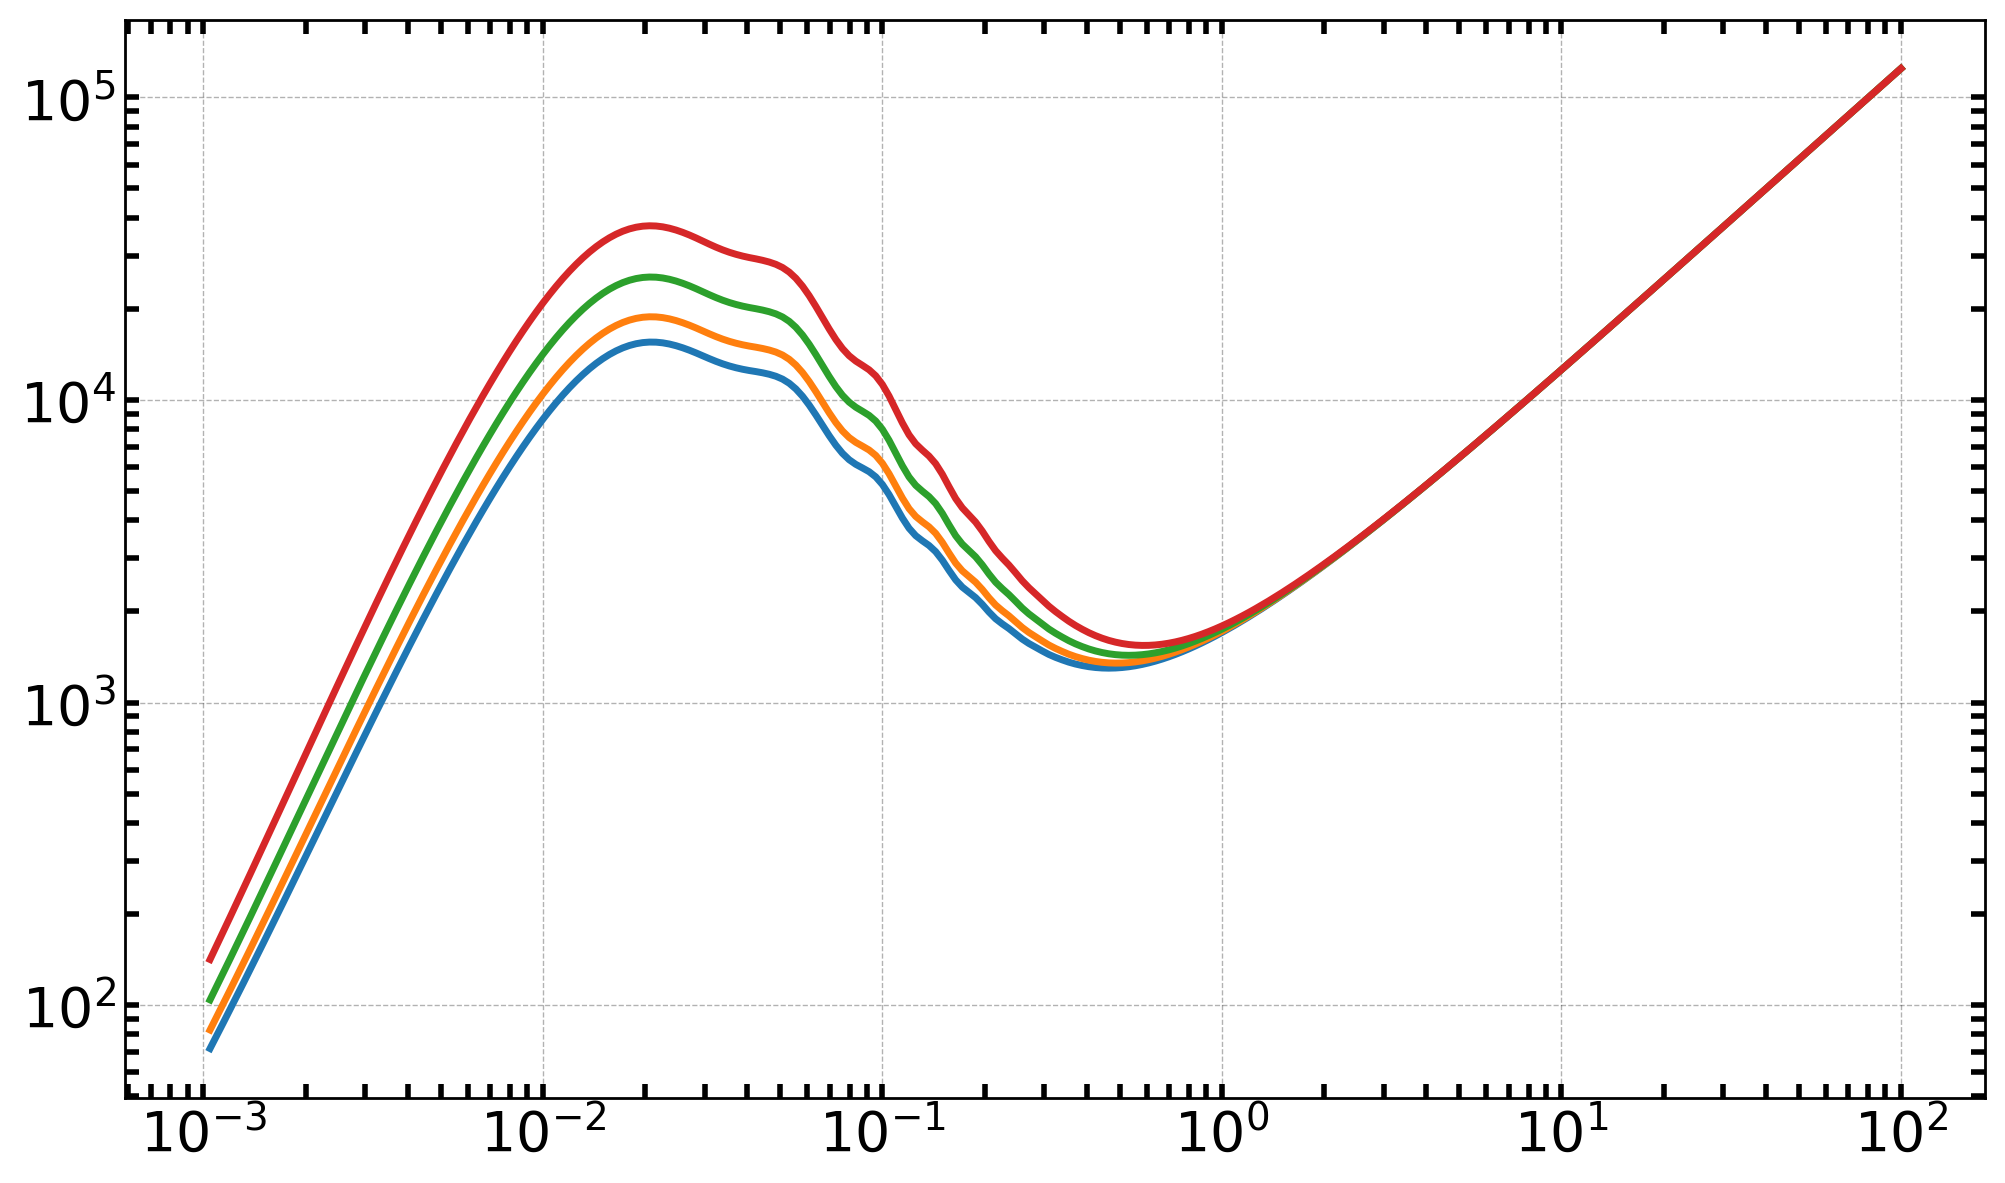

In [98]:
plt.loglog()
for i in range(4):
    sig = np.diag(covs[i])
    plt.plot(kvec[1:], 2*sig/Nki)

In [117]:
1/8

0.125

In [116]:
5000/(4*np.pi*57.295**2)

0.12120671830668632

/tmp/ipykernel_6013/3093565498.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


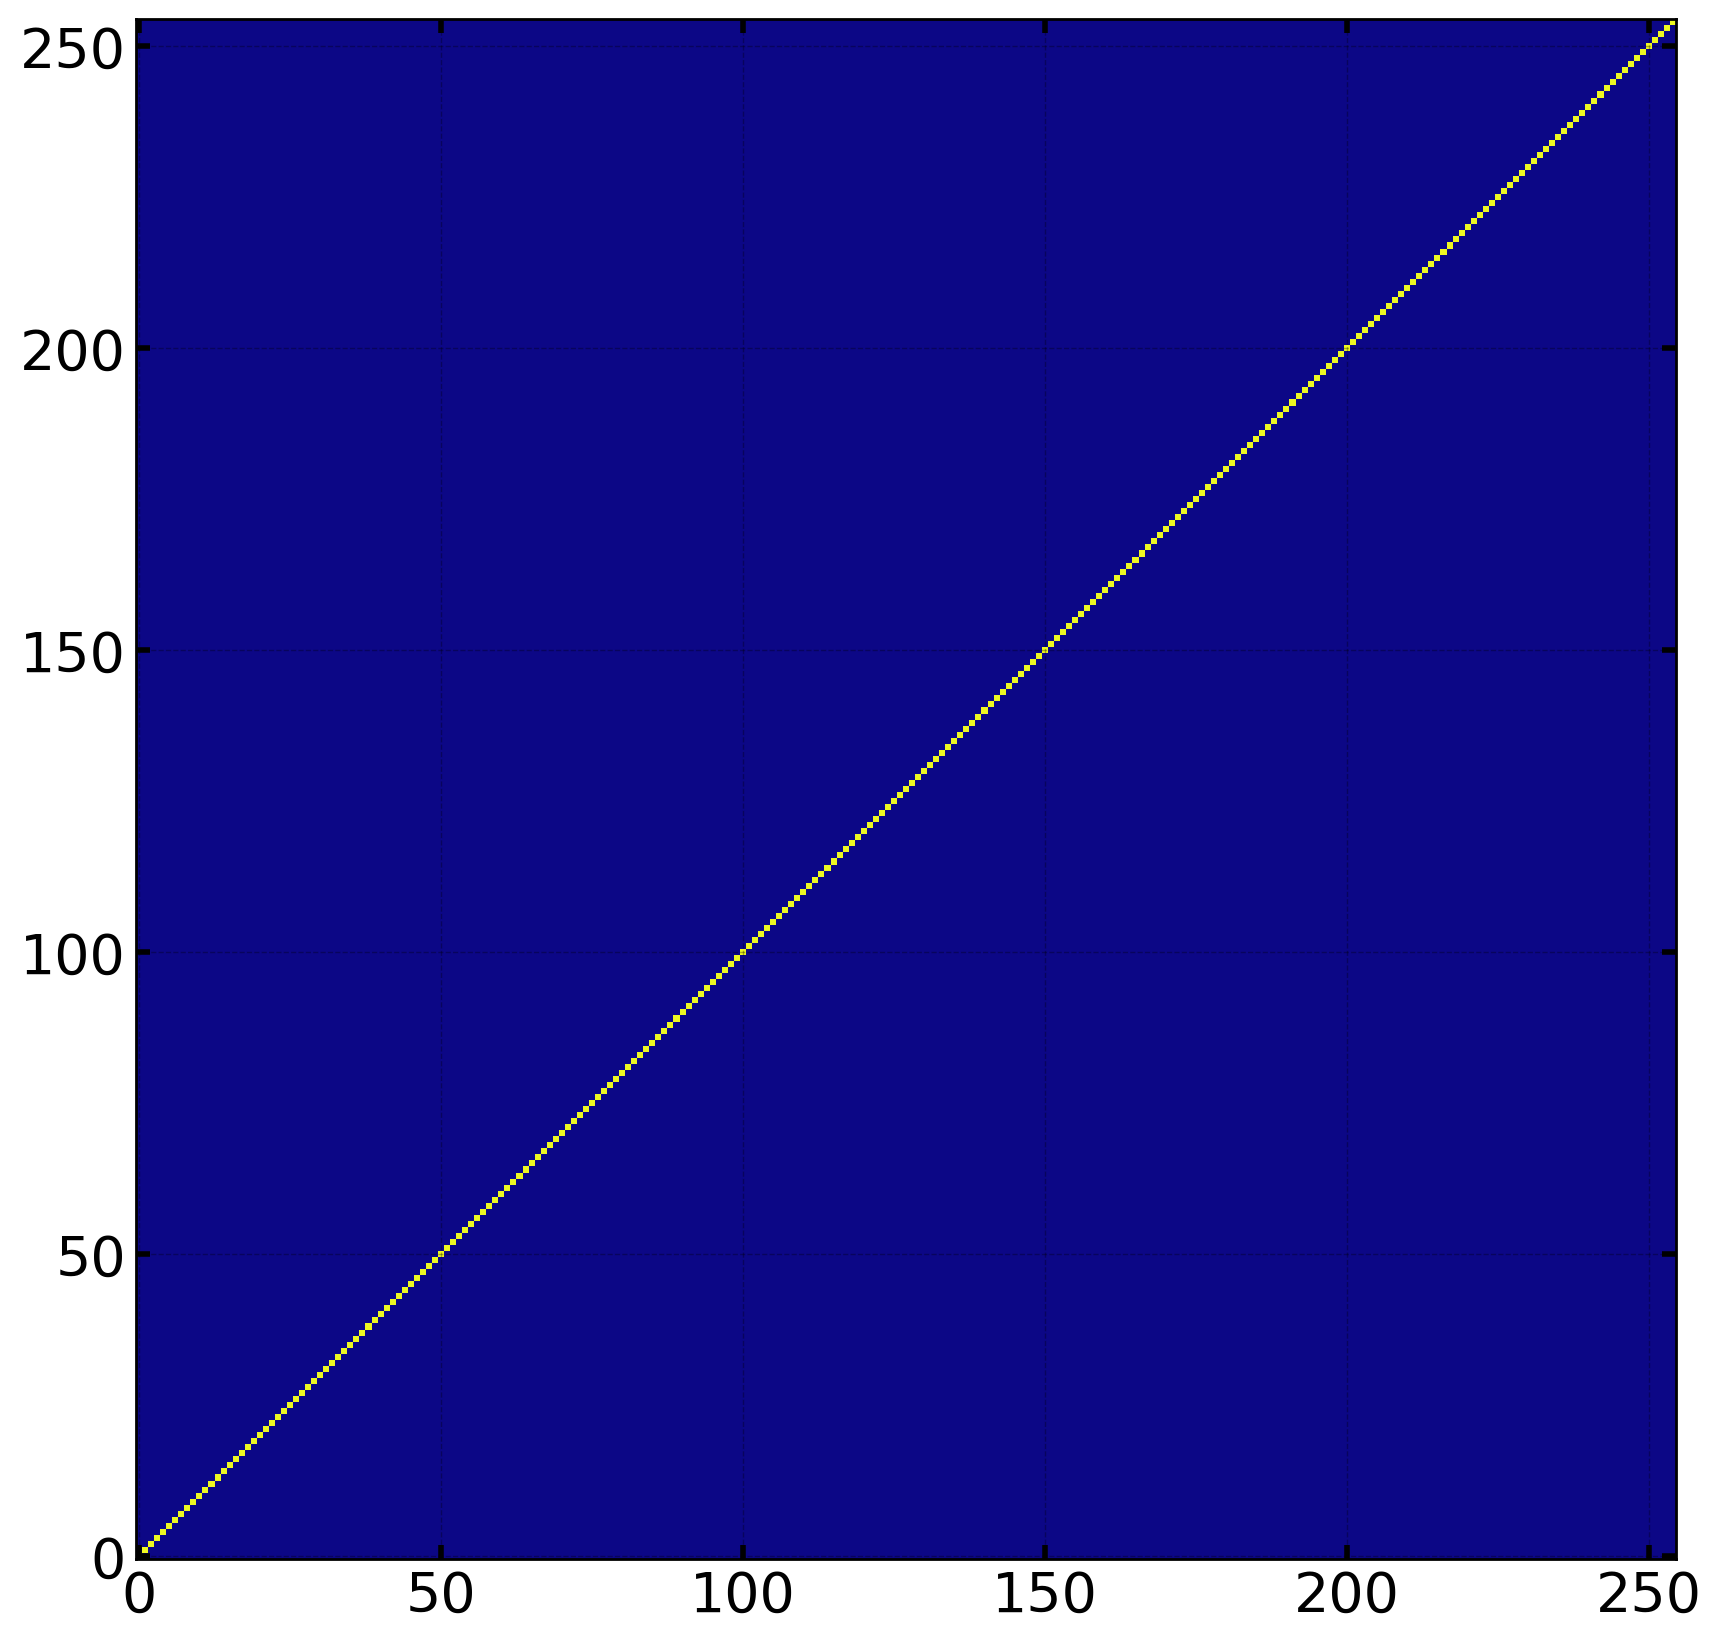

In [231]:
from matplotlib.colors import LogNorm, PowerNorm
from scipy.ndimage.filters import gaussian_filter

coefs = np.corrcoef(covs[0])

cmap = 'plasma'
vmin, vmax = 0.01, 1.
plt.figure(figsize=(10,10))
img = plt.imshow(gaussian_filter(coefs, 0.15), origin='lower', norm=PowerNorm(gamma=4, vmin=vmin, vmax=vmax), cmap=cmap)

# for i in range(nz):
#     plt.axhline(i*nr, color='w', lw=3)

# for i in range(nl):
#     plt.axvline(i*nr, color='w', lw=3)

# plt.colorbar(img, shrink=0.6)
# plt.title('Covariance: ' + kw['gamma'] )


In [228]:
# help(interp1d)

# Correlation Function $\xi_{hh}(r)$

## Running Instructions

MPI is needed to run the function `SurveyData2PCF` from  `nbodykit`. The code don't work on jupyter environments only trough scripts. To activate the script is 
need to activate the MPI on nersc accordingly. Following the instructions the code documentation
```
salloc --nodes 6 --qos interactive --time 01:00:00 --constraint haswell --account=des
source /global/common/software/m3035/conda-activate.sh 3.7
```

After setting up, you can run using `srun`

```
srun -n 180 python run.py 1
```

For more instructions take a look at: https://nbodykit.readthedocs.io/en/latest/results/parallel.html

### Load Results

In [264]:
fname = '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z_box%i_all.json'
crfs = []
for i in range(2):
    crfs.append(SurveyData2PCF.load(fname%i))


## Plot 2D

In [265]:
self = crfs[0]
self.attrs

{'mode': 'projected',
 'edges': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
         34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
         45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
         56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
         67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
         78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
         89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
        100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
        111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
        122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
        133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       

In [266]:
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp2d

r2d = self.corr['rp']
# rperp = self.corr['rp'][:,0]

h= 0.7
h2 = h**2
pivec = np.arange(0., 200, 1)*h
rpar = (self.attrs['edges'][:-1]+np.diff(self.attrs['edges'])/2.)
e1, e2 = np.meshgrid(rpar, pivec)

z = self.corr['corr'].T
# z = np.where(z<0, 0., z)
z = gaussian_filter(z, 2)

# e1 /= 0.7
nx, ny = e1.shape
i0, i1 = np.argmin(np.abs(pivec-30)), np.argmin(np.abs(rpar-30))
# print(i0)

/tmp/ipykernel_25471/1944112255.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [267]:
r2d.shape

(249, 200)

In [268]:
rpar

array([  1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,
        19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,
        28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,
        37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,  45.5,
        46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,  54.5,
        55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,  63.5,
        64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,  72.5,
        73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,  81.5,
        82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,  90.5,
        91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,  99.5,
       100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5, 108.5,
       109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5, 116.5, 117.5,
       118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5, 125.5, 126.5,
       127.5, 128.5,

In [269]:
# z

/tmp/ipykernel_25471/3656714267.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(e1[:i0,:i1], e2[:i0,:i1], z[:i0,:i1], norm=LogNorm(vmin, vmax), cmap=cmap)


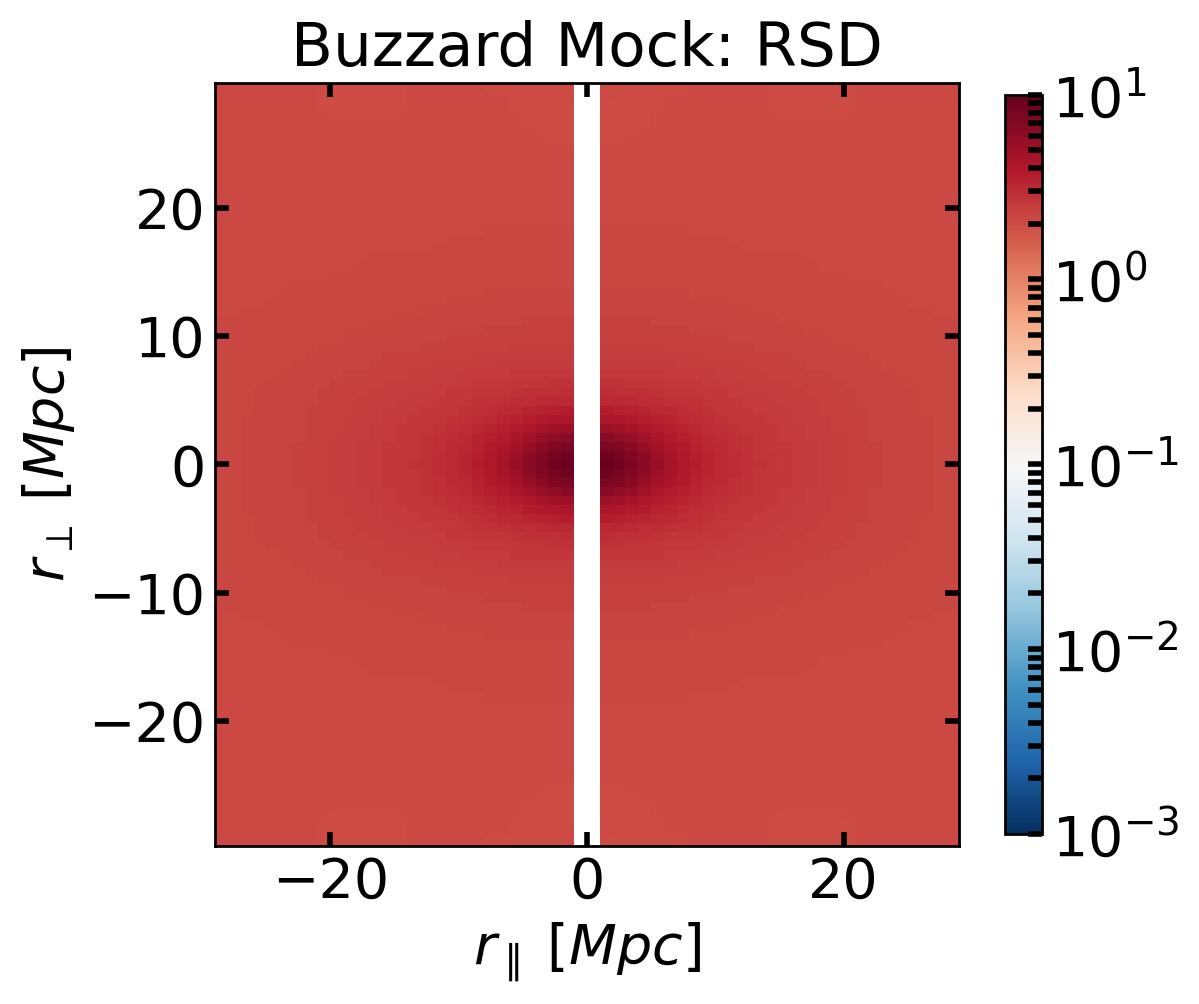

In [270]:
from matplotlib.colors import LogNorm
cmap = 'RdBu_r'
vmin, vmax = 0.001, 10.

fig, ax = plt.subplots(1, 1, figsize=(6, 6.))
im = ax.pcolormesh(e1[:i0,:i1], e2[:i0,:i1], z[:i0,:i1], norm=LogNorm(vmin, vmax), cmap=cmap)
ax.pcolormesh(-e1[:i0,:i1], e2[:i0,:i1], z[:i0,:i1], norm=LogNorm(vmin, vmax), cmap=cmap)
ax.pcolormesh(e1[:i0,:i1], -e2[:i0,:i1], z[:i0,:i1], norm=LogNorm(vmin, vmax), cmap=cmap)
ax.pcolormesh(-e1[:i0,:i1], -e2[:i0,:i1], z[:i0,:i1], norm=LogNorm(vmin, vmax), cmap=cmap)

ax.set_aspect('equal')
fig.colorbar(im, shrink=0.8)
ax.set_ylabel(kwargs['rperp'])
ax.set_xlabel(kwargs['pi'])
ax.set_title('Buzzard Mock: RSD')
fig.savefig('rsd_mock_bin_0.png',dpi=150)

In [271]:
# X.shape

In [272]:
X = z
N = X.shape[0]
l1, l2 = X.shape
xl = np.interp(np.arange(l2), np.arange(rpar.size),rpar)#np.linspace(-180,180,2*l2)
x = np.append(-np.flip(xl),xl)
y = np.linspace(-180,180,2*l1)
# x = rpar
# y = rpar
b1 = np.hstack((np.fliplr(X),X))
b2 = np.flipud(b1)
b = np.vstack((b2,b1))


(-30.0, 30.0)

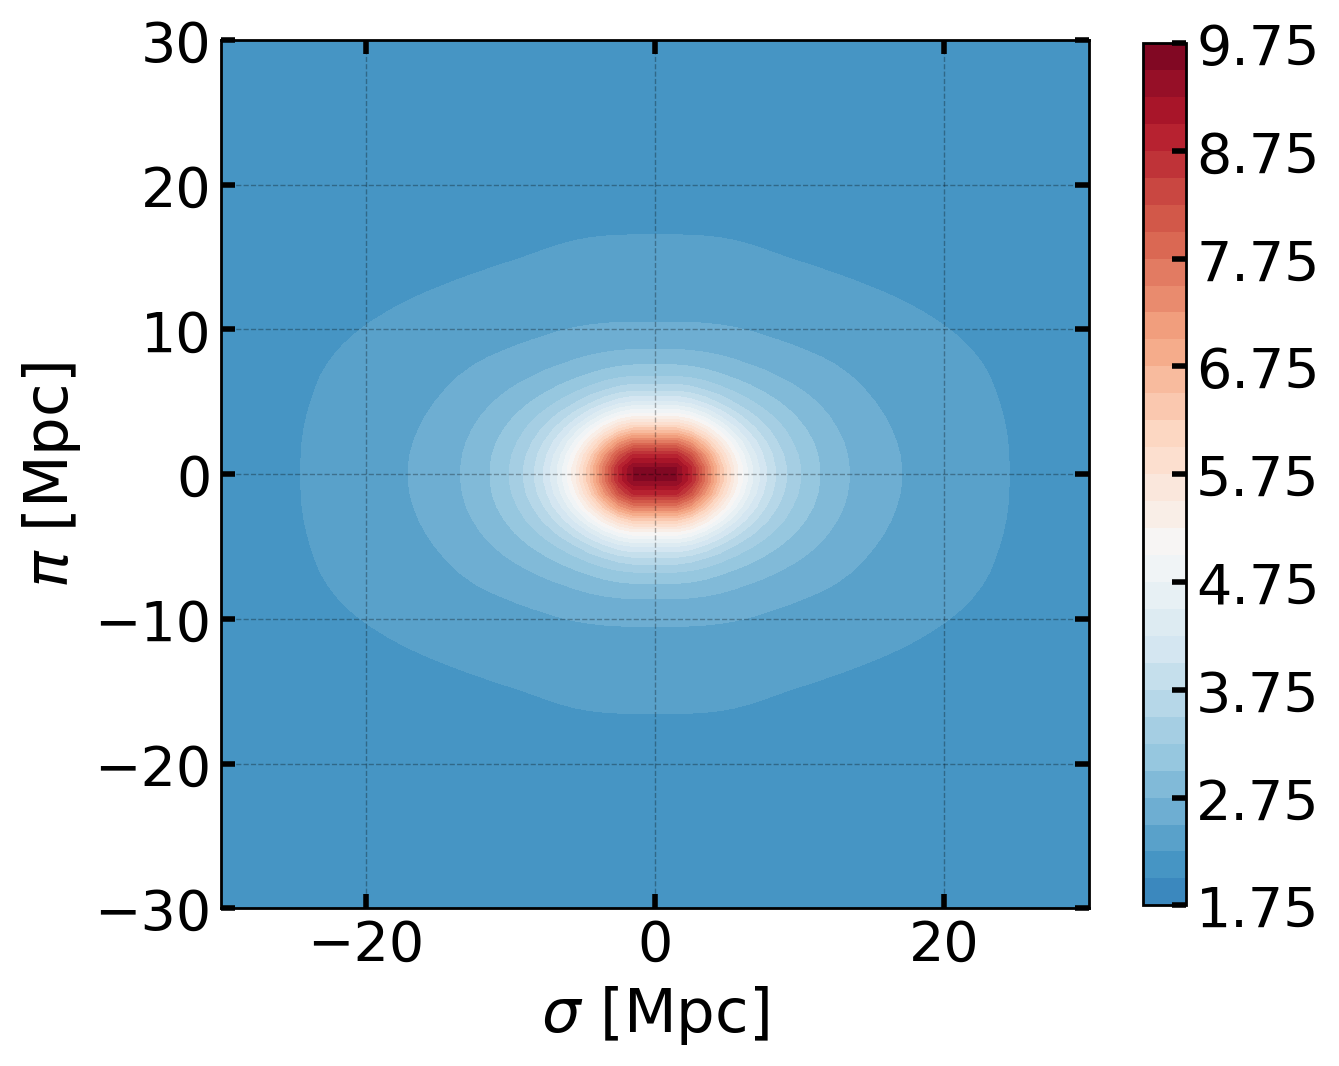

In [273]:
fig, ax = plt.subplots(figsize=(7, 7)) 
ax.set_xlabel(r'$\sigma$ $[\rm{Mpc}]$',fontsize=22)
ax.set_ylabel(r'$\pi$ $[\rm{Mpc}]$',fontsize=22)
#csp=plt.contourf(x, y, b, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
#cbar = fig.colorbar(csp)
plt.contourf(x, y, b, 30, vmin=0.1, vmax=10, cmap='RdBu_r')
plt.colorbar(shrink=0.8);
ax.set_aspect('equal')
plt.xlim(-30, 30)
plt.ylim(-30, 30)

## Convert to $(s, \mu)$

By the spherical coordinates defintion we can convert $(r_{\perp}, \pi)$ to $(s, \mu)$. Basically:
$$
s^2 = r_{\perp}^2+\pi^2
$$
With, $\mu= \cos{\theta}$ being equal to:
$$
\mu = \pi/s
$$

In [274]:
def to_smu(rperp, pivec):
    svec = np.sqrt(rperp**2 + pivec**2)
    muvec = pivec/svec
    return svec, muvec

In [283]:
s2d, mu2d = to_smu(e2, e1)

def get_unitary_vectors(self):
    pivec = np.arange(0., 200, 1)
    rpar = (self.attrs['edges'][:-1]+np.diff(self.attrs['edges'])/2.)
    e1, e2 = np.meshgrid(rpar, pivec)
    return e1, e2

def average_over_mu(self,mumean=0.5, deltaMu=0.5):
    xi_2d = self.corr['corr'].T
    e1, e2 = get_unitary_vectors(self)
    s2d, mu2d = to_smu(e1, e2)
    
    # xi_2d = np.where(xi_2d<0, 0., xi_2d)
    npi, ns = xi_2d.shape
    xi_s = np.zeros((ns,))
    
    for i in range(ns):
        muvec = mu2d[:,i]
        integrand = np.where( np.abs(muvec-mumean)>deltaMu, 0, xi_2d[:,i])
        integrand = np.where(s2d[:,i]>150, 0., integrand)
        xi_s[i] = 2*np.trapz(integrand, x=muvec)
        # xi_s[i] = np.median(xi_2d[:30,i])
    return s2d[0], xi_s


In [284]:
pis, xi_pi = average_over_mu(crfs[0],mumean=1.0, deltaMu=0.5)
s, xi_sigma = average_over_mu(crfs[0],mumean=0.5, deltaMu=0.5)

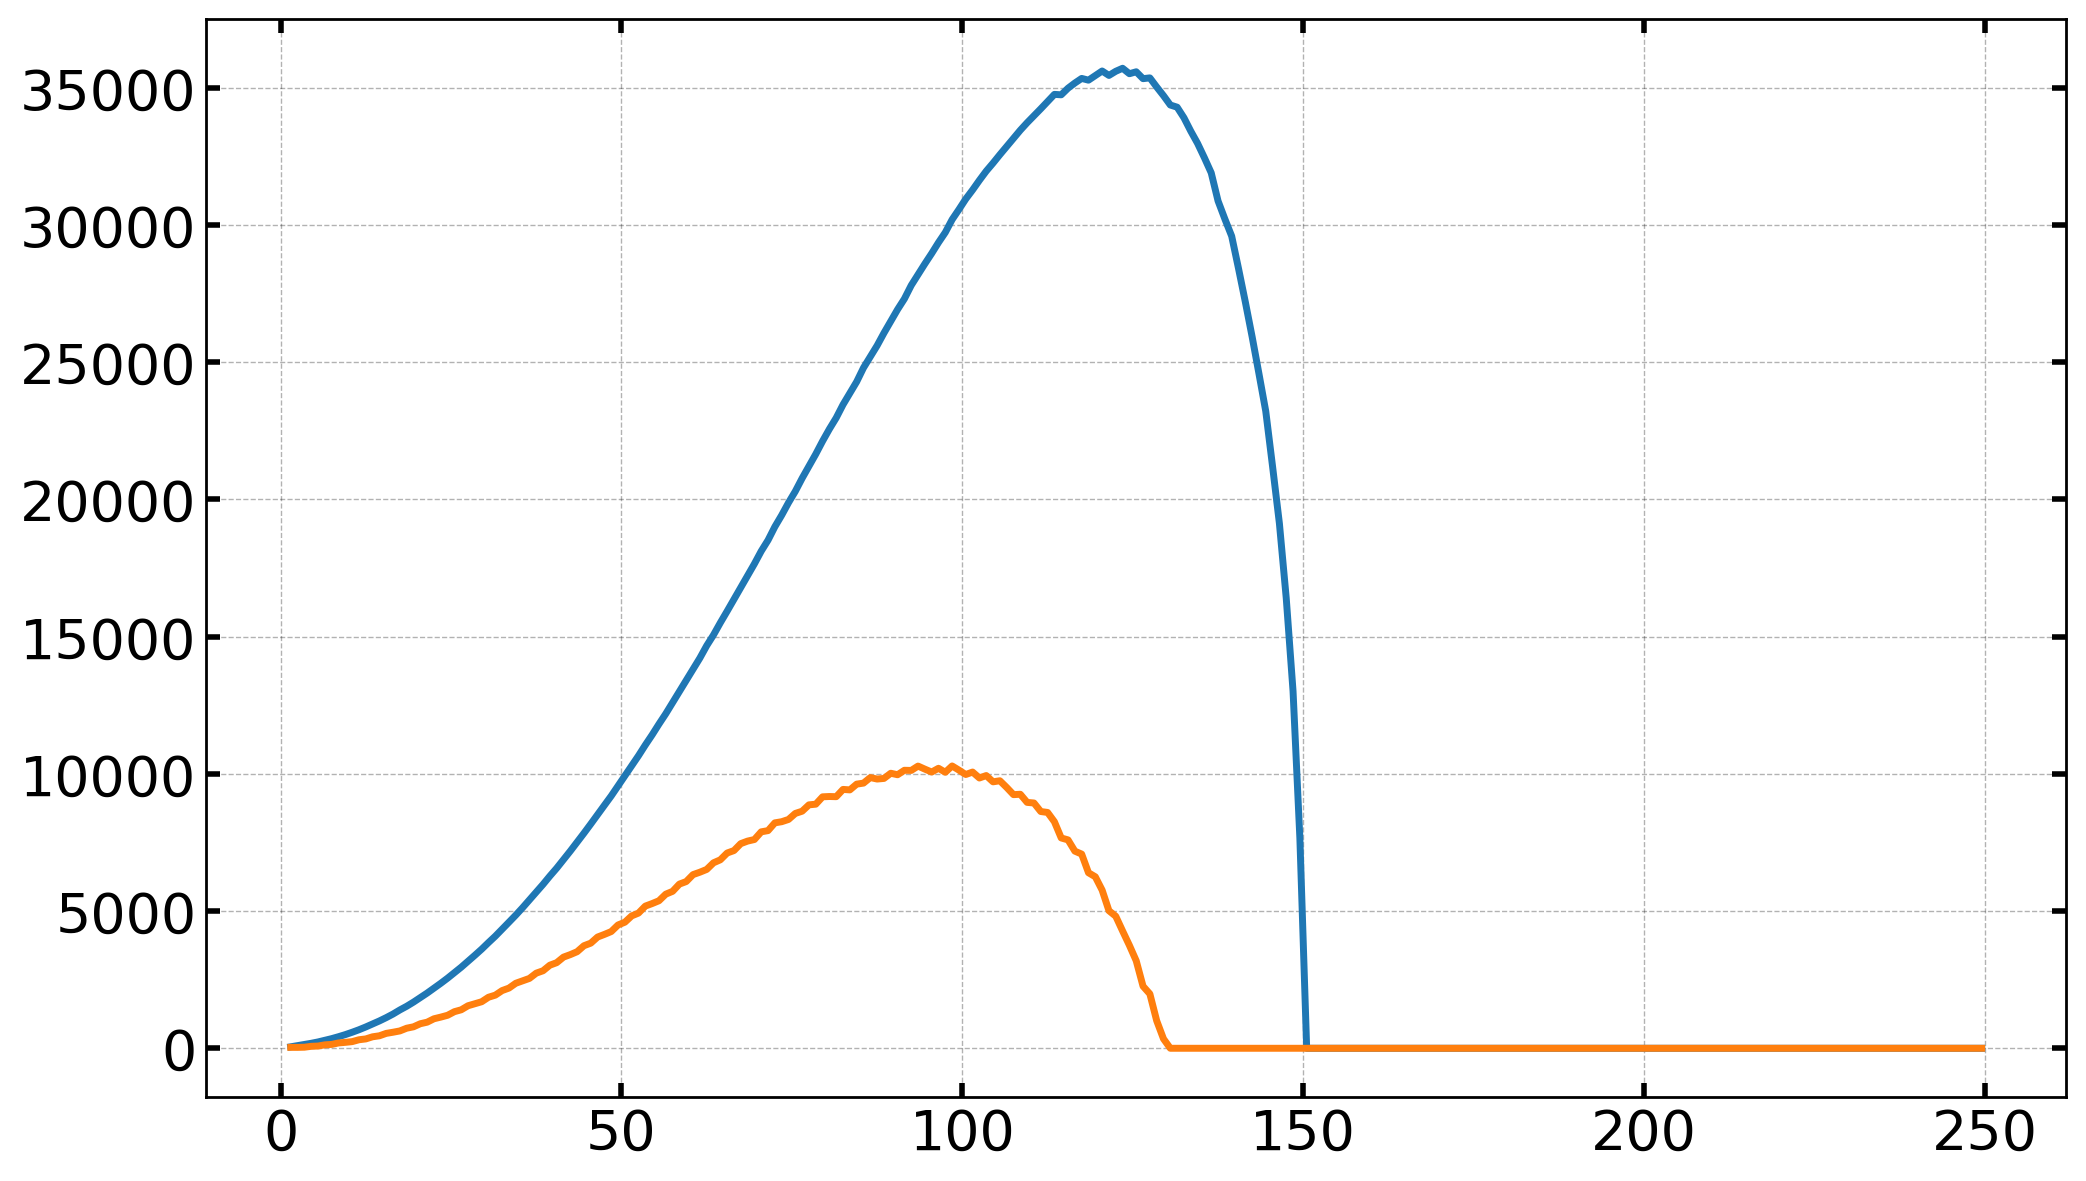

In [286]:
# plt.xscale('log')
plt.plot(s, s*s*xi_sigma)
plt.plot(pis, pis*pis*xi_pi)
# plt.ylim(100,259)
# plt.scatter(s, xi_sigma)
# plt.scatter(pis, xi_pi)


## Profiles

/tmp/ipykernel_25471/1061228193.py:27: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 30)


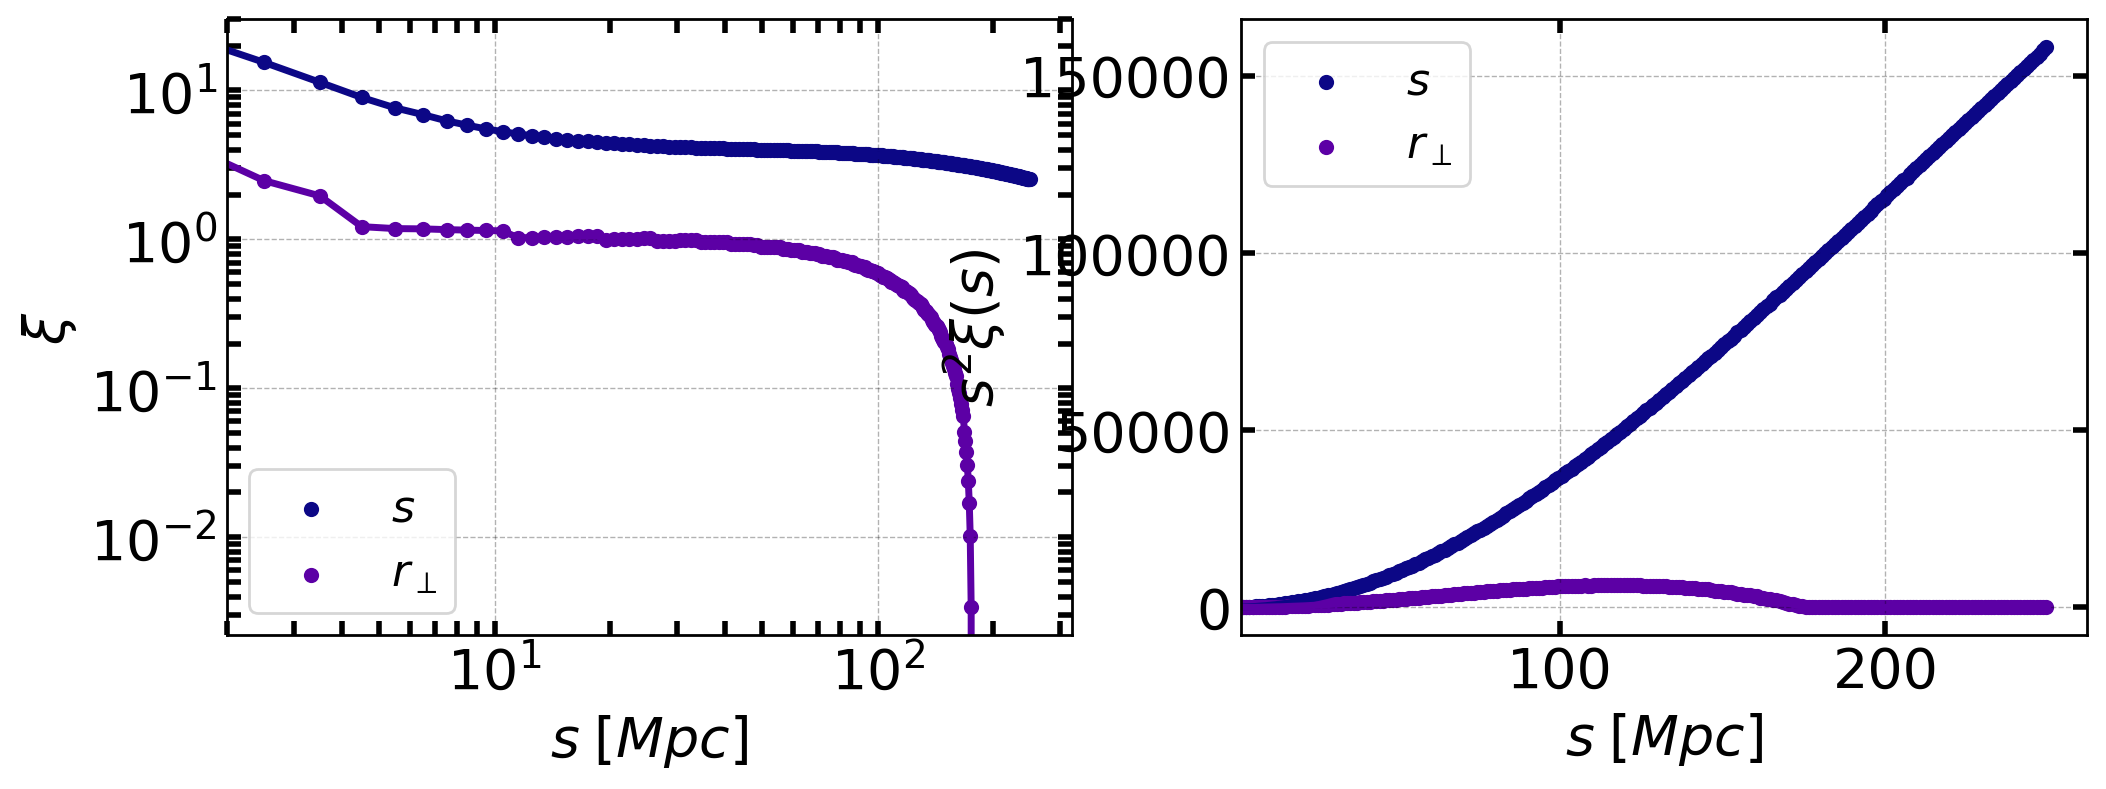

In [279]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.))
self = crfs[0]
# xi_2d = z.T#self.corr['corr']
xi_2d = self.corr['corr'].T
# xi_2d = np.where(xi_2d<0, 0, xi_2d)
# xi_2d = np.where(xi_2d<0, 0, xi_2d)

pis, xi_pi = average_over_mu(self, mumean=1., deltaMu=0.25)
s, xi_s = average_over_mu(self, mumean=0.5, deltaMu=0.5)

# xi_perp  = np.median(xi_2d[0:30,:],0)
# xi_pi = np.where((xi_pi<0.3) | (rpara>100), 0., xi_pi)

ax = axs[0]
ax.loglog()
# ax.set_xscale('log')
ax.scatter(s, xi_s, s=20, color=colors[0],label=r'$s$')
ax.plot(s, xi_s, color=colors[0])

ax.scatter(pis, xi_pi, s=20, color=colors[1],label=r'$r_{\perp}$')
ax.plot(pis, xi_pi, color=colors[1])

ax.legend()
ax.set_xlabel(kwargs['r'])
ax.set_ylabel(kwargs['xi'])
ax.set_xlim(2., )
ax.set_ylim(0, 30)

ax = axs[1]
# ax.loglog()
# ax.set_xscale('log')
xi_s2 = xi_s*s*s
ax.scatter(s, xi_s2, s=20, color=colors[0],label=r'$s$')
ax.plot(s, xi_s2, color=colors[0])

xi_pi2 = pis*pis*xi_pi
ax.scatter(pis, xi_pi2, s=20, color=colors[1],label=r'$r_{\perp}$')
ax.plot(pis, xi_pi2, color=colors[1])
# ax.set_ylim(0, 150)
ax.set_xlim(2., )
ax.legend()
ax.set_xlabel(kwargs['r'])
ax.set_ylabel(kwargs['sxi'])
fig.savefig('xi_profile_mock_bin_0.png',dpi=150)
# ax.set_ylim(5, 300)

### CAMB


In [296]:
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.6 installed at /global/homes/j/jesteves/.conda/envs/for-nbodykit/lib/python3.10/site-packages/camb


In [297]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=70, ombh2=0.046*0.7**2, omch2=0.286*0.7**2)
pars.InitPower.set_params(ns=0.96)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=list(zmeans), kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=1e-5, maxkh=10000, npoints = 1000)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-5, maxkh=10000, npoints = 1000)


Note: redshifts have been re-sorted (earliest first)


In [298]:
import hankl
print("Using hankel v{}".format(hankl.__version__))
# s = rpar
def get_corrFunc(s, k, pk):
    si, xi0 = hankl.P2xi(k, pk, l=0)
    xi0 -= np.min(xi0) 
    xi = interp1d(si, xi0)(s)
    return s, xi

Using hankel v1.1.0


In [299]:
xi_nonlin = np.zeros((3, s.size))
for i in range(3):
    s, crf = get_corrFunc(s, kh_nonlin, pk_nonlin[i])
    xi_nonlin[i] = crf

/tmp/ipykernel_2927/1317786976.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_nonlin[i] = crf


In [300]:
def unpack(self):
    s, xi_s = average_over_mu(self)
    return s, xi_s

In [301]:
# plt.loglog()
# plt.plot(s, xi_nonlin[0])
# np.min(xi_nonlin[0])

In [302]:
# import cluster_toolkit as ct


## Plot Results

In [303]:
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis

colors = Plasma[5]

In [305]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

smin_lim, smax_lim = 3., 50.

bias = []
for zbin in range(2):
    # load data
    s, xi = unpack(crfs[zbin])
    
    mask = (s>=smin_lim)&(s<=smax_lim)

    # load model
    xi_camb = interp1d(s, xi_nonlin[zbin])
    xi_cls = lambda x,b: b**2*xi_camb(x)*x*x

    # fit the data
    popt, pcov = curve_fit(xi_cls, s[mask], s[mask]*s[mask]*xi[mask])
    bias.append(float(popt))

In [306]:
bias

[11.561254089214923, 12.537724117169617]

Text(0.5, 1.0, 'Buzzar Mock - Cluster P(k)')

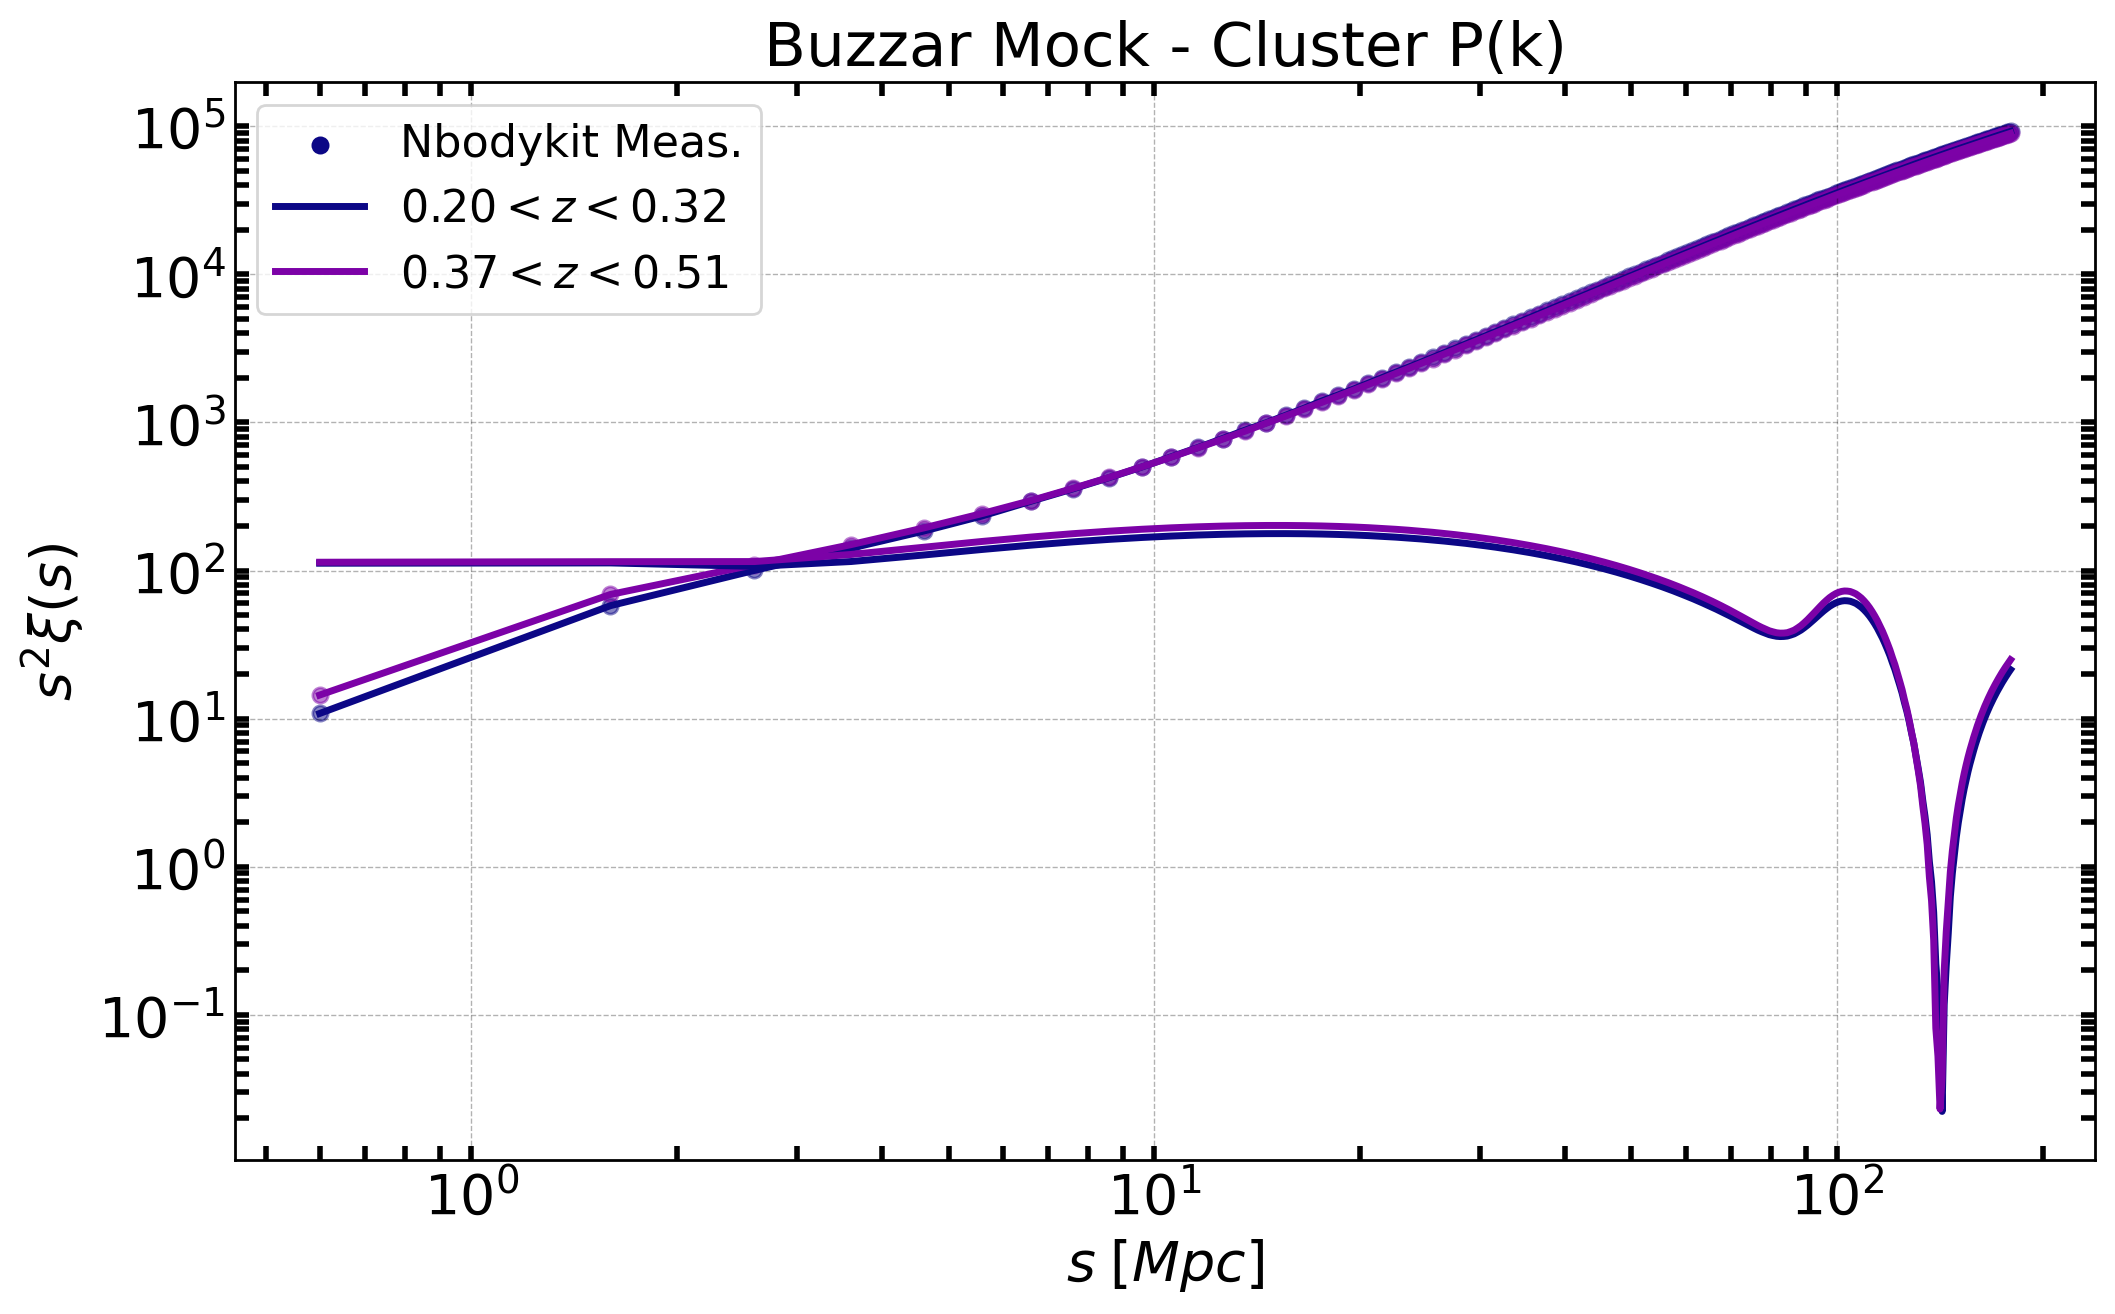

In [310]:
# s = rpar
plt.loglog()
# plt.xscale('log')
for i in range(2):
    s, xi = unpack(crfs[i])
    plt.scatter(s, s*s*xi, color=colors[i], alpha=0.5, s=30)
    plt.plot(s, s*s*xi, '-', color=colors[i])
plt.scatter([0],[0], color=colors[0], s=30, label='Nbodykit Meas.')

bias = 2.5*((1+zmeans)/(1+0.25))**(1.1)
for i in range(2):
    xi = bias[i]**2*xi_nonlin[i]
    #plt.scatter(s, s*s*xi, color=colors[i], alpha=0.5, s=30)
    plt.plot(s, s*s*xi, '-', color=colors[i], label=zlabel[i])

# plt.ylim(30., 250)
plt.legend(loc=0)
plt.xlabel(kwargs['r'])
plt.ylabel(kwargs['sxi'])
plt.title('Buzzar Mock - Cluster P(k)')

In [ ]:
# plt.scatter(zmeans, bias)

In [ ]:
fnamebase = '2PCF_zbin_%i.npz'
for i in range(3):
    fname = fnamebase%i
    s, xi = unpack(crfs[i])
    np.savez(fname, s=s, xi=xi)

In [41]:
# rm 2PCF_zbin_%i.npz 

## Jackknife

In [639]:
!ls /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi*

/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k0.json
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k1.json
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k2.json
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k3.json
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k4.json
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k5.json
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k6.json
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k7.json
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k8.json
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k9.json
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/

In [10]:
fname = '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z1_k%i.json'

kcrfs = []
for i in range(10):
    kcrfs.append(SurveyData2PCF.load(fname%i))

NameError: name 'unpack' is not defined

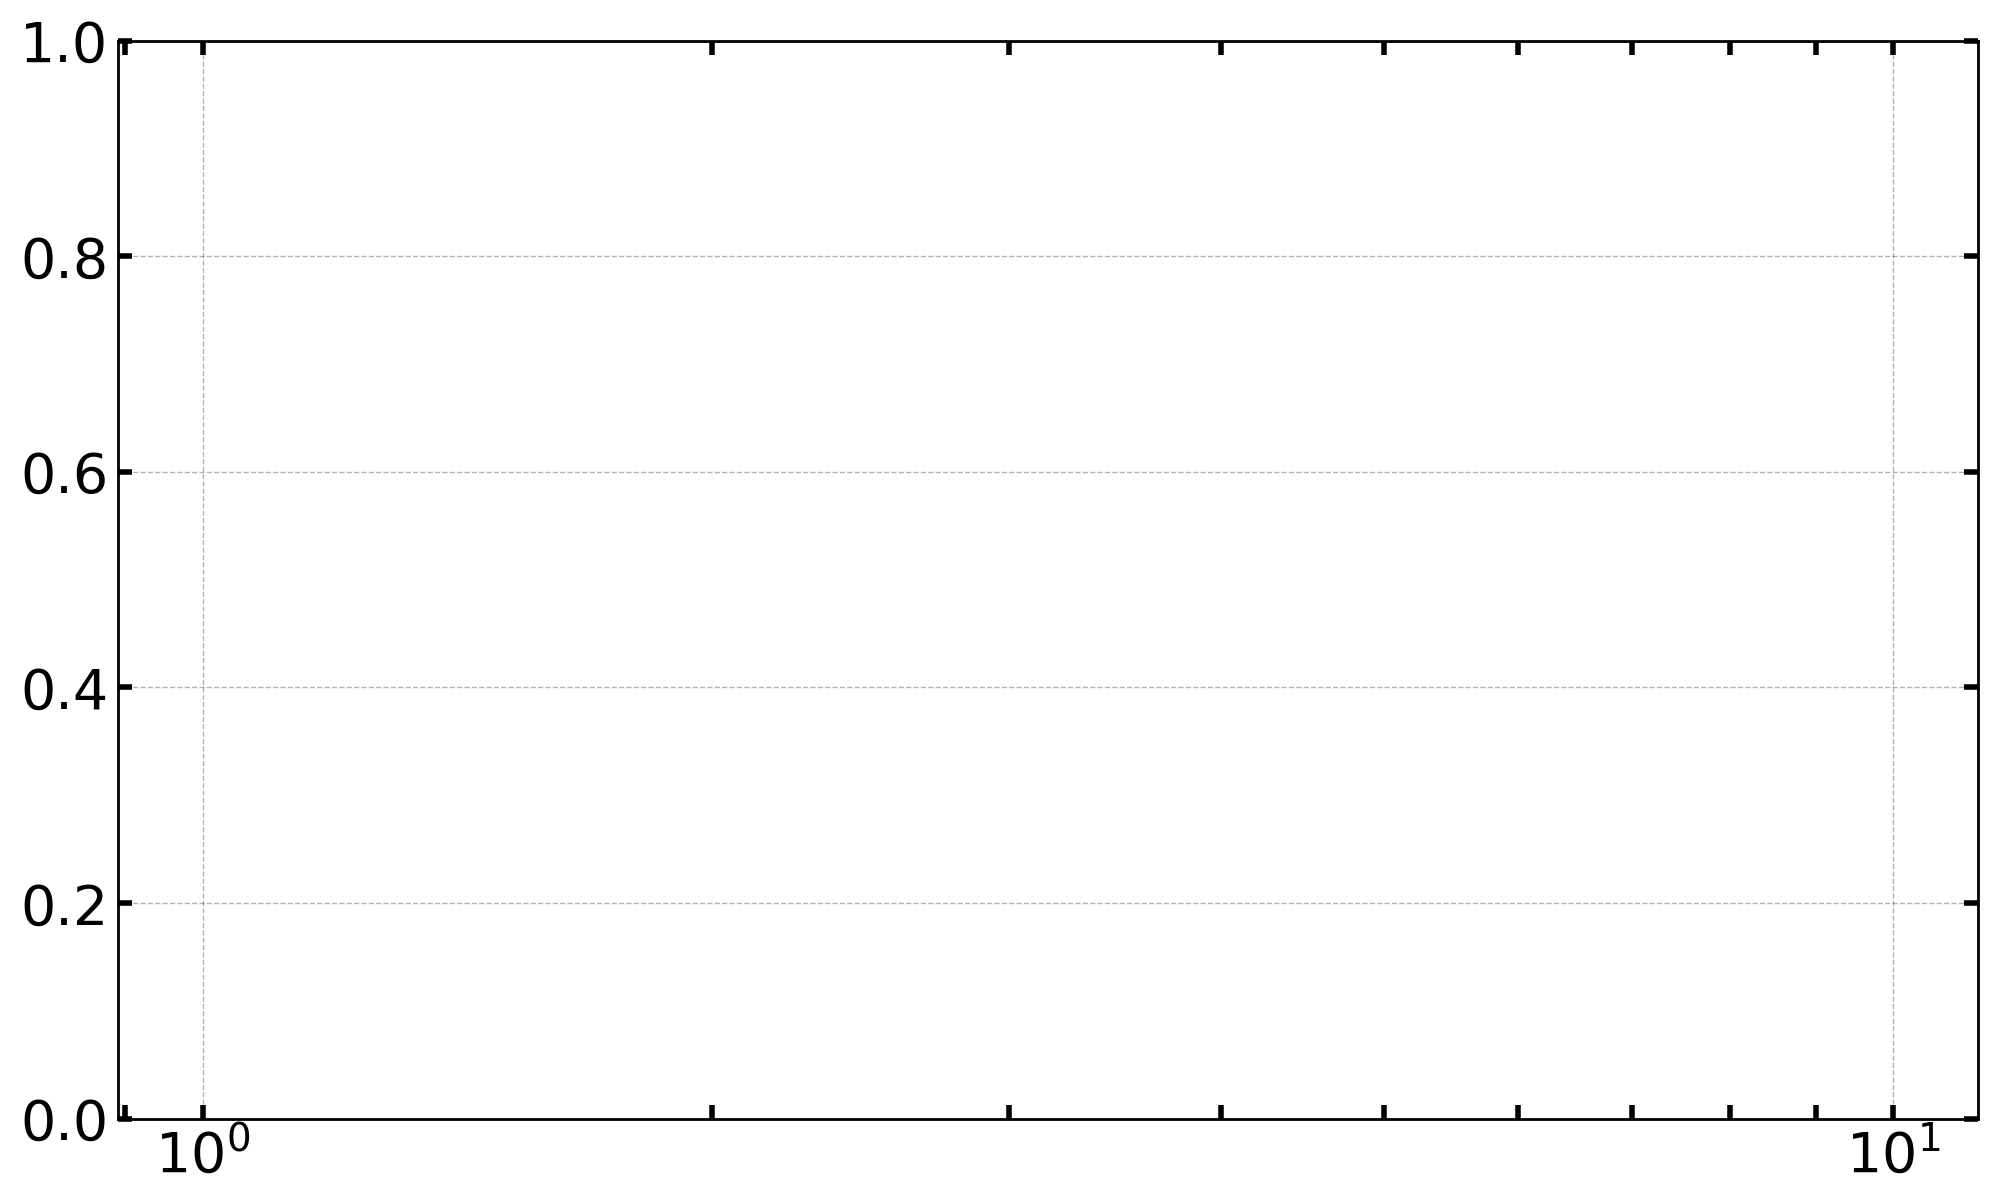

In [11]:
# plt.loglog()
plt.xscale('log')
i=1
s, xi = unpack(crfs[i])
plt.scatter(s, s*s*xi, color='k', alpha=0.5, s=30)
plt.plot(s, s*s*xi, '-', color='k', label='all')

for i in range(10):
    s, xi = unpack(kcrfs[i])
    plt.scatter(s, s*s*xi, alpha=0.5, s=30, label='Group = %i'%i)
    #plt.plot(s, s*s*xi, '-')

# plt.scatter([0],[0], color=colors[0], s=30, label='Nbodykit Meas.')
# bias = 2.15*((1+zmeans)/(1+0.25))**(1.2)
# for i in range(3):
#     xi = bias[i]**2*xi_nonlin[i]
#     #plt.scatter(s, s*s*xi, color=colors[i], alpha=0.5, s=30)
#     plt.plot(s, s*s*xi, '-', color=colors[i], label=zlabel[i])
plt.xlim(2.5, 50)
plt.ylim(0., 300)
plt.legend(loc=0)
plt.xlabel(kwargs['r'])
plt.ylabel(kwargs['xi'])
plt.title('Jackknife')

## Power Spectrum

In [175]:
!ls -lth /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/*.json

-rw-rw---- 1 jesteves des  93K Nov 28 14:01 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z0_all.json
-rw-rw---- 1 jesteves des  91K Nov 28 14:01 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z2_all.json
-rw-rw---- 1 jesteves des  92K Nov 28 14:01 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z1_all.json
-rw-rw---- 1 jesteves des 3.8M Nov 28 11:31 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z2_all.json
-rw-rw---- 1 jesteves des 3.7M Nov 28 11:31 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z1_all.json
-rw-rw---- 1 jesteves des 3.7M Nov 28 11:30 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z0_all.json


In [176]:
fname = '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z%i_all.json'
powers = []
for i in range(3):
    powers.append(ConvolvedFFTPower.load(fname%i))


In [243]:
from scipy.ndimage import uniform_filter1d

kvec = np.logspace(-3, np.log10(2.), 50)

def roll_average(self, i=0, k_break=0.22, Nl=20, Nu=10, kmin=0.01, kmax=2.0):
    power = self.poles.sel(k=slice(kmin, kmax),method='nearest')
    P = power['power_%i'%i].real 
    if i==0: P -= power.attrs['shotnoise']
    isnan = np.isnan(np.log(P))
    k, pk = power['k'][~isnan], P[~isnan]
    log_k, log_pk = np.log(k), np.log(pk)

    # rolling average
    y = uniform_filter1d(pk, size=int(k.size/Nl)+1)
    y2 = uniform_filter1d(pk, size=int(k.size/Nu)+1)
    ix = np.where(k>0.22)[0]
    y[ix] = y2[ix]
    return k, pk, y


In [244]:
# def do_sum(self, k_break=0.22, kmin=0.01, kmax=2.0):
self = powers[0]
# use the same number of mu wedges and number of multipoles
Nmu = Nell = 5
mu_edges = numpy.linspace(0, 1, Nmu+1)

# get a BinnedStatistic holding the P(k,mu) wedges
Pkmu = self.to_pkmu(mu_edges, 4)

power_mu = Pkmu['power'].real - Pkmu.attrs['shotnoise']

power_mu

array([[           nan,            nan,            nan,            nan,
                   nan],
       [ 1.0116608e+07,  1.1053090e+07,  1.1617434e+07,  9.1924070e+06,
        -1.4784434e+05],
       [ 3.9545550e+06,  3.6925092e+06,  3.2011328e+06,  2.5458562e+06,
         1.8248251e+06],
       ...,
       [ 5.9399453e+03,  5.8067422e+03,  5.6520156e+03,  5.6991875e+03,
         6.2833203e+03],
       [ 6.0949688e+03,  5.9763750e+03,  5.8378125e+03,  5.8765938e+03,
         6.3886328e+03],
       [ 6.0036484e+03,  5.9934766e+03,  6.0054375e+03,  6.1041562e+03,
         6.3865703e+03]], dtype=float32)

In [179]:
# plt.loglog()
# plt.plot(Pkmu['k'], Pkmu['power'].real - Pkmu.attrs['shotnoise'])

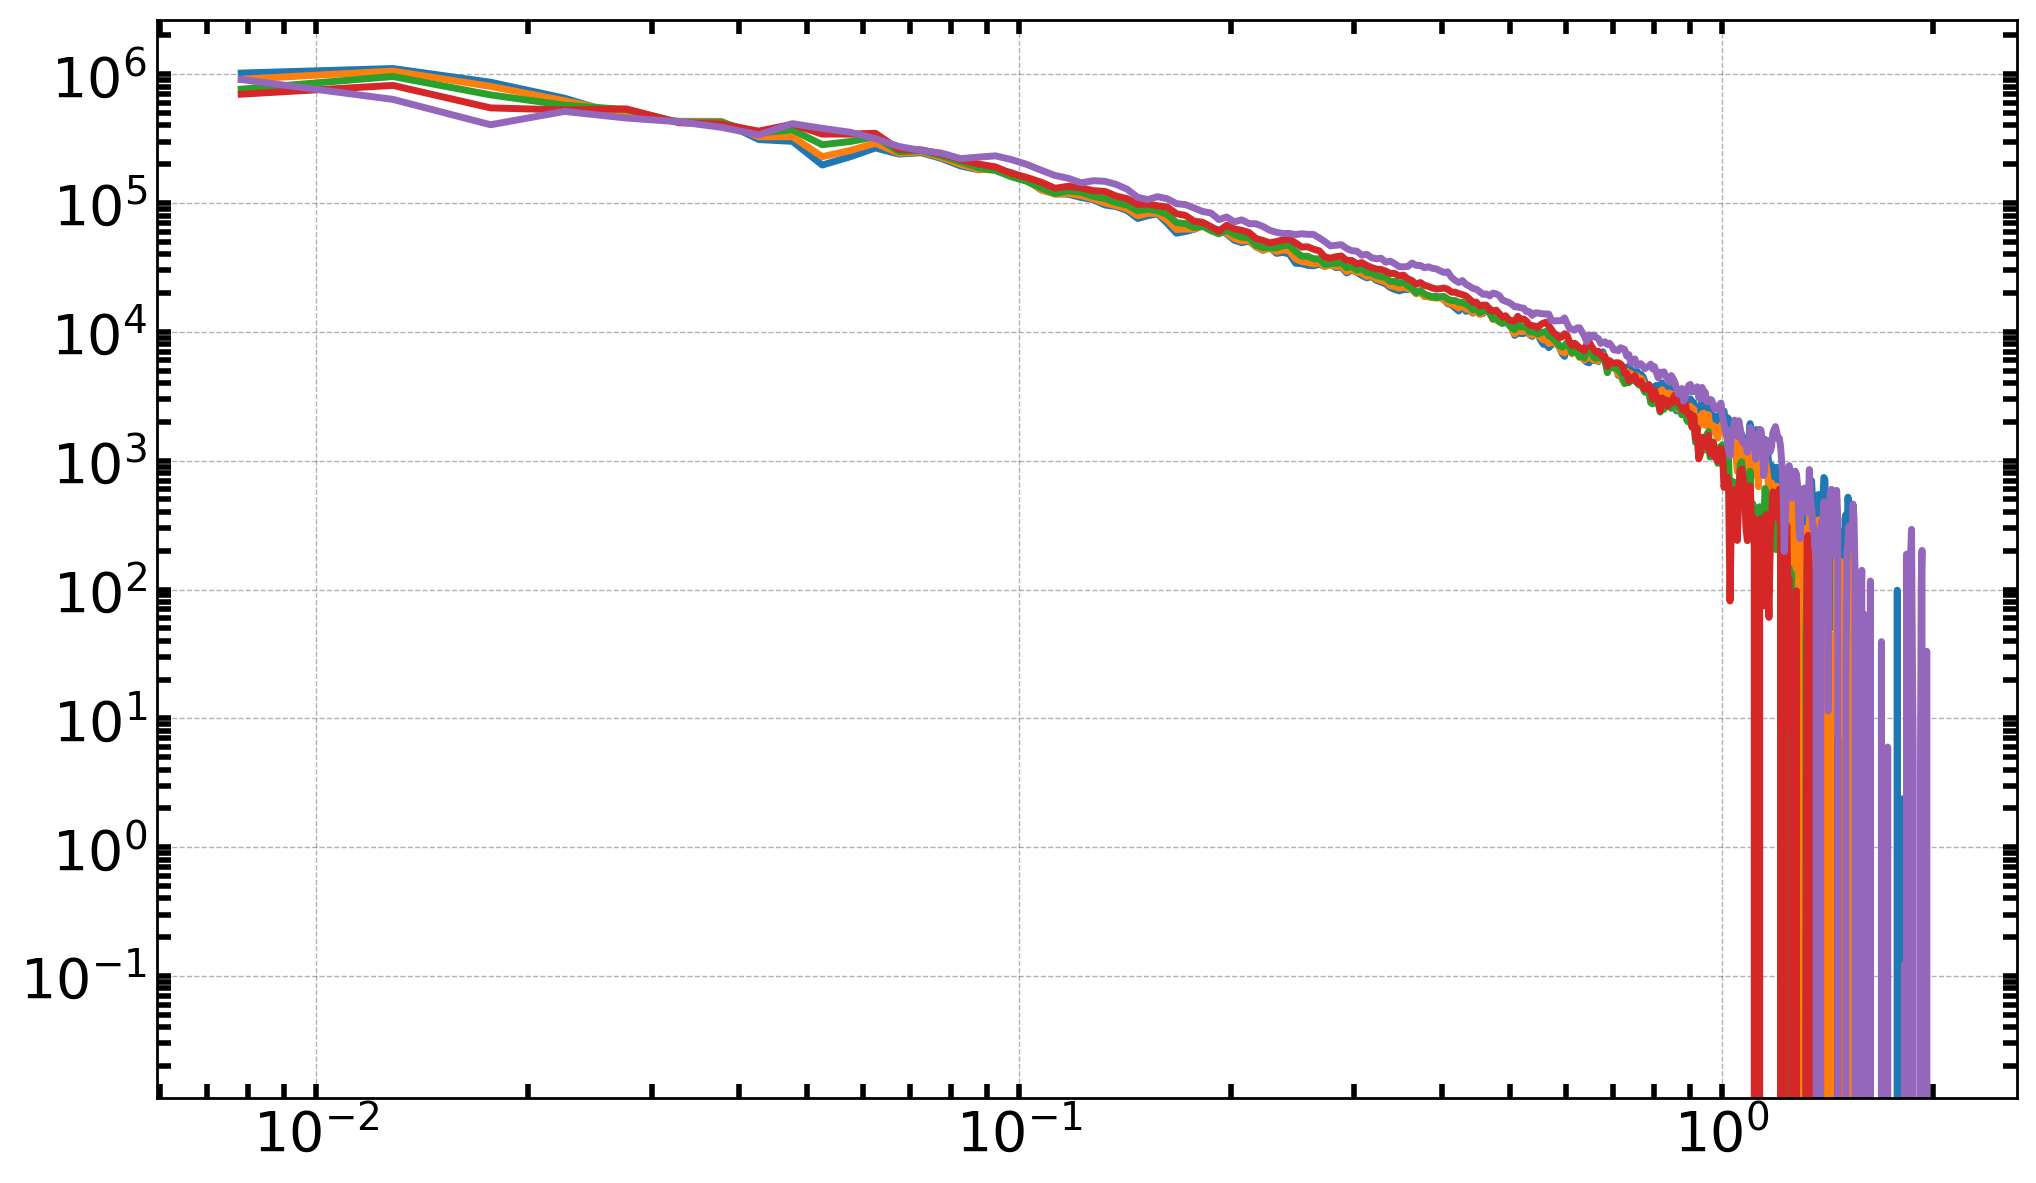

In [180]:
plt.loglog()
plt.plot(Pkmu['k'], Pkmu['power'].real - Pkmu.attrs['shotnoise'])

In [18]:
# plt.imshow()

In [19]:
# mu_means = mu_edges[:-1]+np.diff(mu_edges)

# z = np.log10(Pkmu['k']*Pkmu['power'].real)
# x = Pkmu['k']*(mu_means)
# y = Pkmu['k']*(1-mu_means)
# c = plt.pcolormesh(x, y, z, cmap ='Greens')
# # plt.colorbar(c)

In [20]:
# Pkmu['k']

/tmp/ipykernel_610/1689884862.py:9: RuntimeWarning: invalid value encountered in log
  isnan = np.isnan(np.log(P))


Text(0.5, 1.0, 'Buzzard Mock - Cluster P(k)')

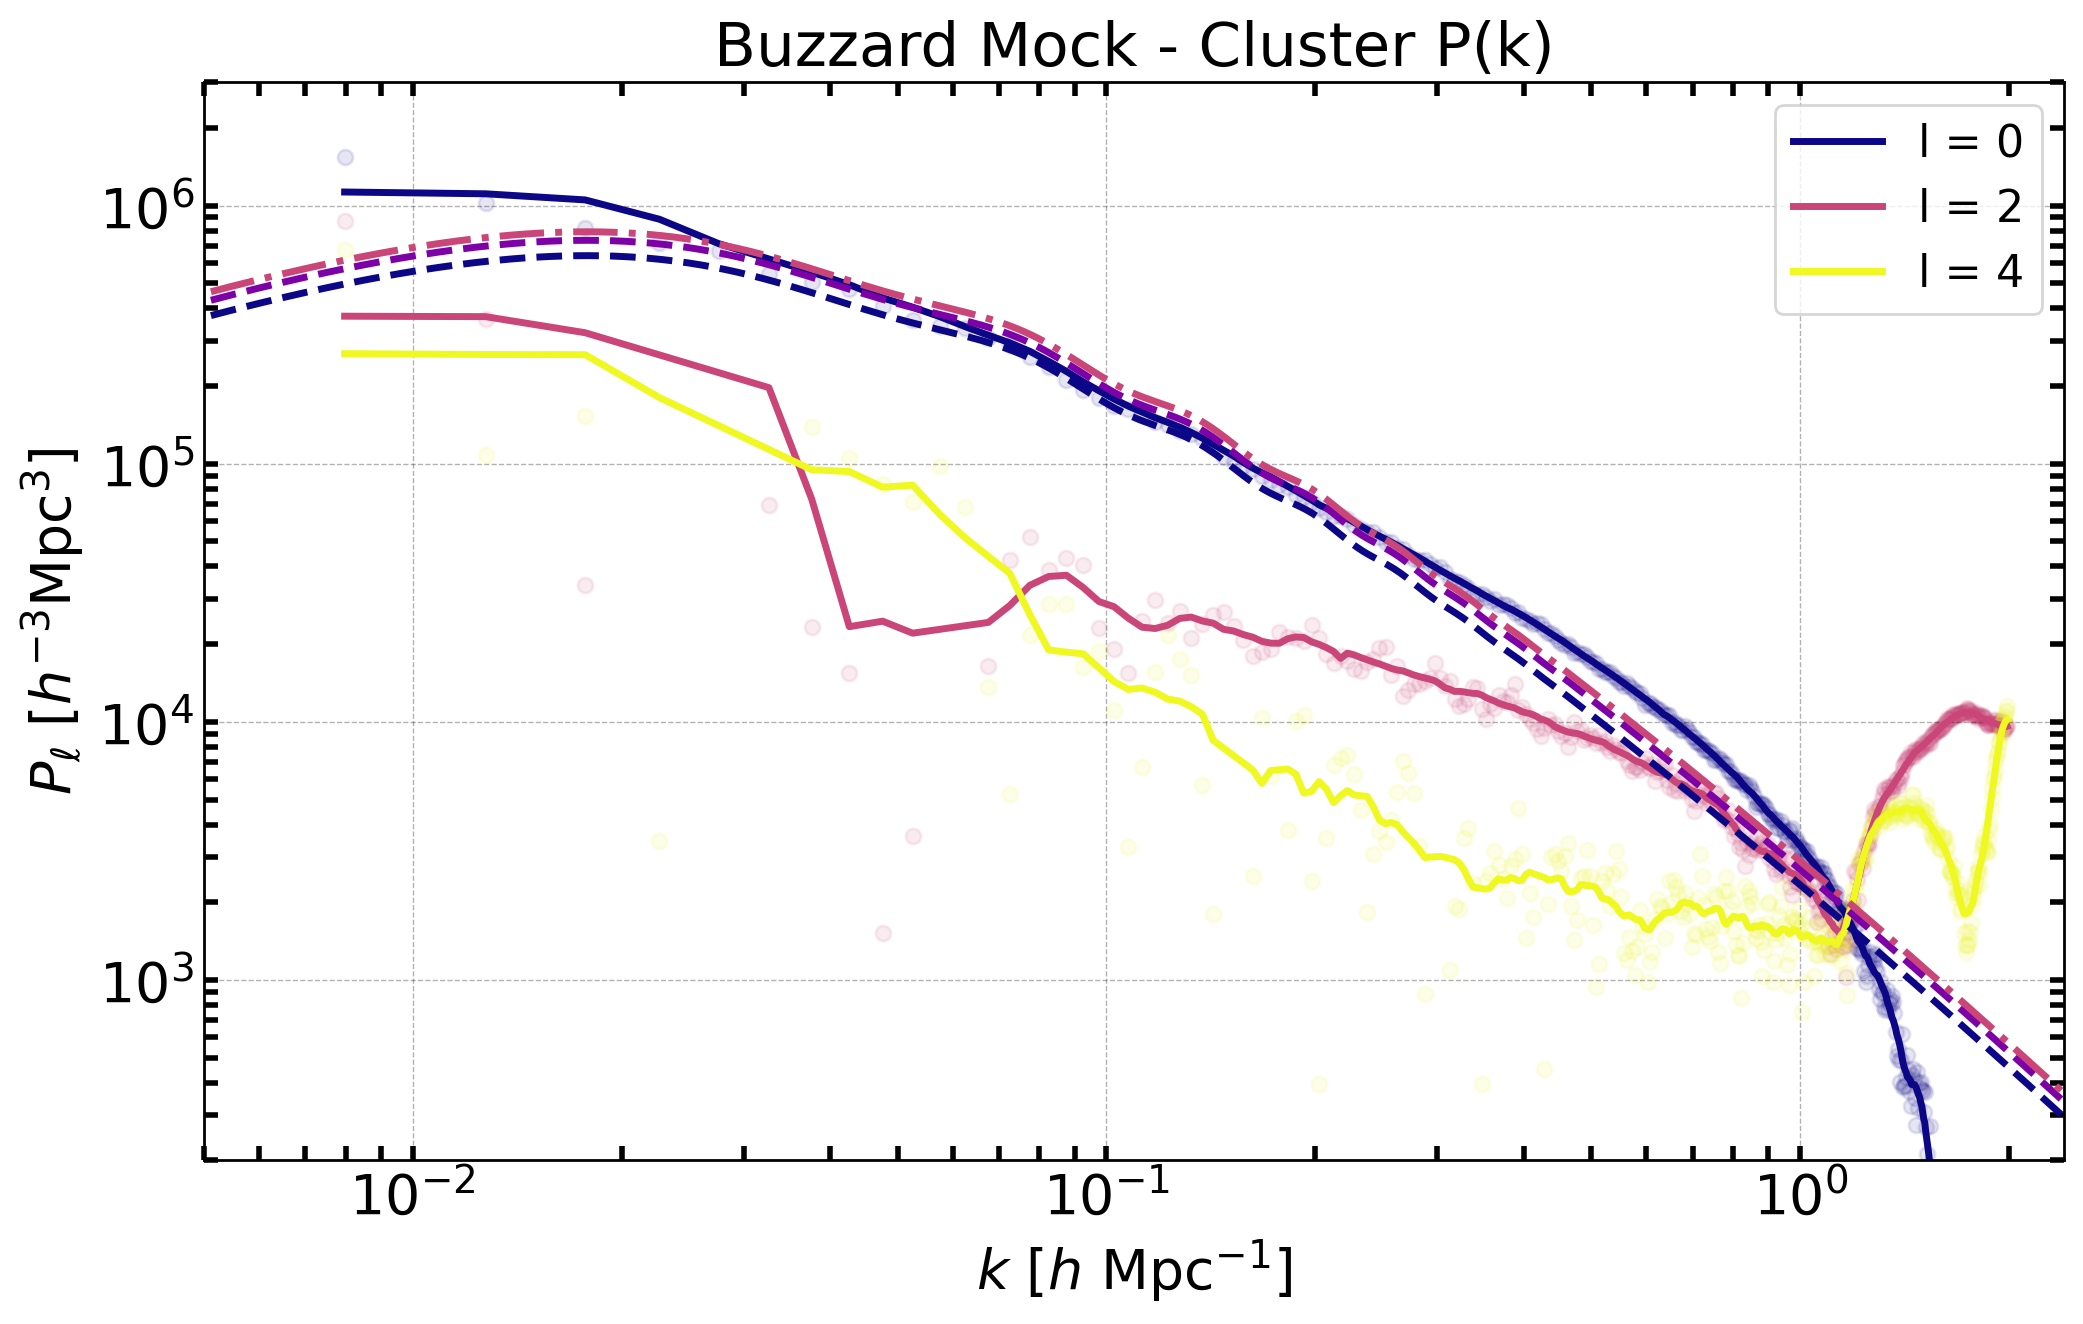

In [181]:
plt.loglog()
# plt.xscale('log')
avg_pks = []
for i in [2]:
    for j in [0, 2, 4]:
        k, pk, pk_avg = roll_average(powers[i], i=j, k_break=0.01, Nl=60, Nu=20)
        plt.scatter(k, pk, color=colors[j], alpha=0.1, s=30)
        plt.plot(k, pk_avg, '-', color=colors[j], label='l = %i'%j)
        avg_pks.append([k, pk])

b=6.7
bias = 6.*((1+zmeans)/(1+0.25))**(1.2)
for i, (redshift, line) in enumerate(zip(list(zmeans),['--','--','-.'])):
    #plt.loglog(kh_lin, b**2*pk_lin[i,:], color=colors[i], ls = line)
    plt.loglog(kh_lin, bias[i]**2*pk_lin[i,:], color=colors[i], ls = line)

plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P_\ell$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.01/2., 2.4)
plt.ylim(2e2, 3e6)
plt.title('Buzzard Mock - Cluster P(k)')

In [23]:
# Under Construction
# from scipy.special import sici

# Msol = 1.98847e33
# Mpc2cm = 3.086e+24

# def pk_nfw(k_h, z, m200, omega_m=0.3):
#     c = cM.get_concentration(cosmoc, m200, 1/(1+z))
#     r200, rho_c = convert_m200_r200(m200, z)
    
#     rho_nfw_k = nfw_fourrier(k_h,r200,c)
    
#     # given xi=(rho_nfw - rhom)/rhom, rhom is a number, then after the hankel transformation is only a multplication factor
#     # the hankel transformation of a constant is a dirac at k=0, i.e. 0
#     pk_nfw = (rho_nfw_k)#/(rho_c*omega_m)
#     return pk_nfw

# #--- Critical universe density
# def rhoc(z):
#     rho_c = (cosmo0.critical_density(z)).value # in g/cm**3
#     rho_c = rho_c*(Mpc2cm**3)/Msol # in Msol/Mpc**3
#     return rho_c

# def convert_m200_r200(M200,z, nc=200):
#     ## M200 in solar masses
#     ## R200 in Mpc
#     rho = nc*rhoc(z)
#     r200 = (3*M200/(4*np.pi/rho))**(1/3.)
#     return r200/1e9, rho

# def nfw_fourrier(k_h,r_virial,c):
#     r_scale = r_virial/c # in Mpc/h units

#     ks = k_h*r_scale

#     sici1 = sici(ks);
#     sici2 = sici(ks*(1.+c))
#     f1 = np.sin(ks)*(sici2[0]-sici1[0]);
#     f2 = np.cos(ks)*(sici2[1]-sici1[1]);
#     f3 = np.sin(c*ks)/(ks*(1.+c));
#     fc = np.log(1.+c)-c/(1.+c);
#     return (f1+f2-f3)/fc